# Analisi fMRI task riconoscimento emozioni

## Librerie

In [1]:
import nibabel as nib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from nilearn import plotting
from nilearn import datasets
from ipywidgets import interact, IntSlider, VBox, HBox, Output
from nilearn import datasets, plotting, image, masking
from nilearn.image import resample_to_img, resample_img
import seaborn as sns
from nilearn.image import resample_to_img
from scipy.signal import butter, filtfilt
from scipy.stats import ttest_ind
from scipy.stats import ttest_ind, t
from nilearn.datasets import fetch_atlas_juelich
import plotly.graph_objects as go
from scipy.stats import norm
import networkx as nx
import matplotlib.cm as cm
import community as community_louvain
import matplotlib.pyplot as plt
from nilearn.input_data import NiftiLabelsMasker
from nilearn.plotting import plot_roi
from IPython.display import display
from matplotlib.lines import Line2D
from scipy.stats import ttest_ind, mannwhitneyu, levene, bartlett, ks_2samp, anderson_ksamp, pearsonr, spearmanr
from statsmodels.tsa.stattools import adfuller, kpss
from scipy.stats import linregress
from matplotlib.colors import LinearSegmentedColormap

## Importare file nii e mostrare sezioni principali 

In [2]:
file_path = '/Users/digitalangels/Desktop/wrsub-01_task-emotionalfaces_run-1_bold.nii'
fmri_img = nib.load(file_path)
fmri_data = fmri_img.get_fdata()

In [3]:
timepoint = 10
fmri_volume = fmri_data[:, :, :, timepoint]
fmri_volume_mean = np.mean(fmri_data, axis=3)  # Media su tutte le scansioni temporali

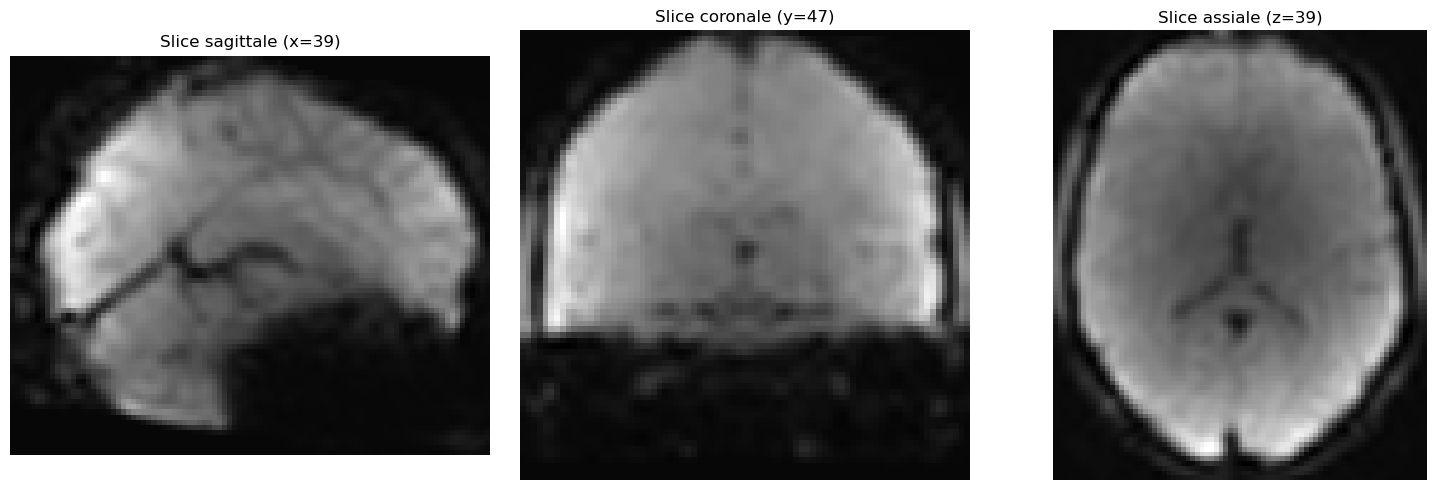

In [4]:
x_center = fmri_volume.shape[0] // 2
y_center = fmri_volume.shape[1] // 2
z_center = fmri_volume.shape[2] // 2

plt.figure(figsize=(15, 5))

# Slice lungo l'asse sagittale (x)
plt.subplot(1, 3, 1)
plt.imshow(fmri_volume[x_center, :, :].T, cmap="gray", origin="lower")
plt.title(f"Slice sagittale (x={x_center})")
plt.axis("off")

# Slice lungo l'asse coronale (y)
plt.subplot(1, 3, 2)
plt.imshow(fmri_volume[:, y_center, :].T, cmap="gray", origin="lower")
plt.title(f"Slice coronale (y={y_center})")
plt.axis("off")

# Slice lungo l'asse assiale (z)
plt.subplot(1, 3, 3)
plt.imshow(fmri_volume[:, :, z_center].T, cmap="gray", origin="lower")
plt.title(f"Slice assiale (z={z_center})")
plt.axis("off")

plt.tight_layout()
plt.show()

In [5]:
dim_x, dim_y, dim_z, dim_t = fmri_data.shape
print(f"Dimensioni fMRI: {fmri_data.shape} (x, y, z, tempo)")

Dimensioni fMRI: (79, 95, 79, 185) (x, y, z, tempo)


/opt/anaconda3/envs/neuro_env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/anaconda3/envs/neuro_env/lib/python3.9/site-packages/nilearn/image/resampling.py:756: UserWarning: Casting data from int32 to float32
  return resample_img(



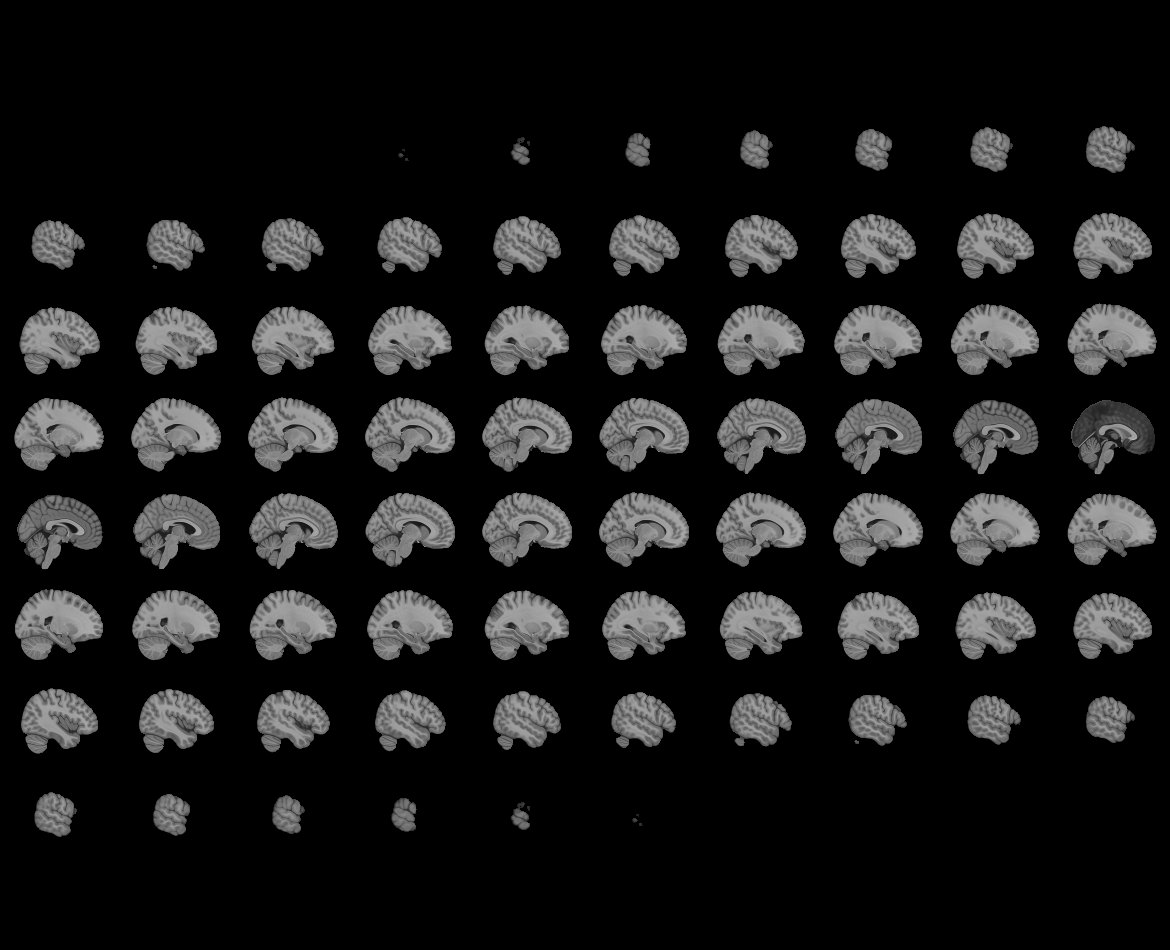
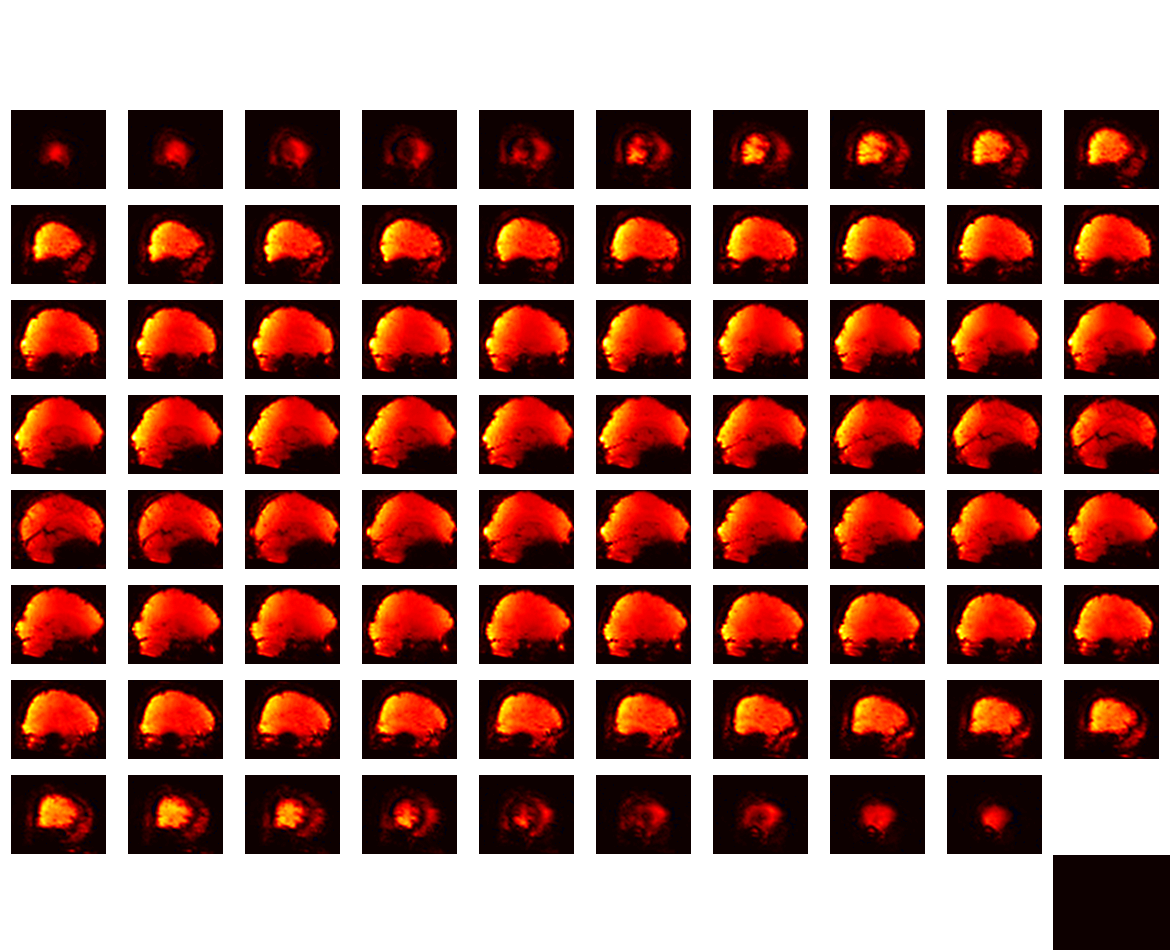

In [6]:
fmri_3d = fmri_img.slicer[..., 0]  # Primo volume temporale (indice 0)
interactive_display = plotting.view_img(fmri_3d, threshold=None, title='Volume Temporale 0')
interactive_display

## Importare atlante e creare maschera 

In [7]:
juelich_atlas = datasets.fetch_atlas_juelich('maxprob-thr25-1mm')
juelich_atlas_img = juelich_atlas.maps  # Questo è già un oggetto NIfTI
juelich_data = juelich_atlas_img.get_fdata()
print(f"Dimensioni dell'atlante Juelich: {juelich_data.shape} (x, y, z)")

Dimensioni dell'atlante Juelich: (182, 218, 182) (x, y, z)


In [8]:
juelich_areas_of_interest = [4, 5, 6, 7, 14, 15, 16, 17, 18, 19, 20, 27, 31, 32, 44, 45, 46, 47]

In [9]:
juelich_data = juelich_atlas_img.get_fdata() 
print(f"Dimensioni dell'atlante Juelich: {juelich_data.shape}")

Dimensioni dell'atlante Juelich: (182, 218, 182)


In [10]:
juelich_areas_of_interest = [4, 5, 6, 7, 14, 15, 16, 17, 18, 19, 20, 27, 31, 32, 44, 45, 46, 47]

In [11]:
juelich_mask = np.zeros_like(juelich_data, dtype=np.int16)
for region in juelich_areas_of_interest:
    juelich_mask[juelich_data == region] = region

# Controlla i valori unici nella maschera
print(f"Valori unici nella maschera originale: {np.unique(juelich_mask)}")

Valori unici nella maschera originale: [ 0  4  5  6  7 14 15 16 17 18 19 20 27 31 32 44 45 46 47]


In [12]:
juelich_mask_img = nib.Nifti1Image(juelich_mask, affine=juelich_atlas_img.affine)

In [13]:
resampled_mask_img = resample_to_img(
    source_img=juelich_mask_img, 
    target_img=fmri_img, 
    interpolation="nearest"
)

In [14]:
output_path = "/Users/digitalangels/Desktop/data/resampled_mask_img"
nib.save(resampled_mask_img, output_path)
print(f"Maschera salvata in: {output_path}")

Maschera salvata in: /Users/digitalangels/Desktop/data/resampled_mask_img


In [15]:
resampled_mask_data = resampled_mask_img.get_fdata().astype(np.int16)
print(f"Valori unici nella maschera resample-ata: {np.unique(resampled_mask_data)}")

Valori unici nella maschera resample-ata: [ 0  4  5  6  7 14 15 16 17 18 19 20 27 31 32 44 45 46 47]


In [16]:
matching_regions = [region for region in np.unique(resampled_mask_data) if region in juelich_areas_of_interest]
print(f"Regioni di interesse trovate nella maschera resample-ata: {matching_regions}")

# Solleva un errore se non ci sono regioni trovate
if len(matching_regions) == 0:
    raise ValueError("Nessuna regione di interesse trovata nella maschera resample-ata.")

Regioni di interesse trovate nella maschera resample-ata: [4, 5, 6, 7, 14, 15, 16, 17, 18, 19, 20, 27, 31, 32, 44, 45, 46, 47]


In [17]:
fmri_mean_data = np.mean(fmri_data, axis=3)  # Media lungo l'asse temporale
fmri_3d = nib.Nifti1Image(fmri_mean_data, affine=fmri_img.affine) 

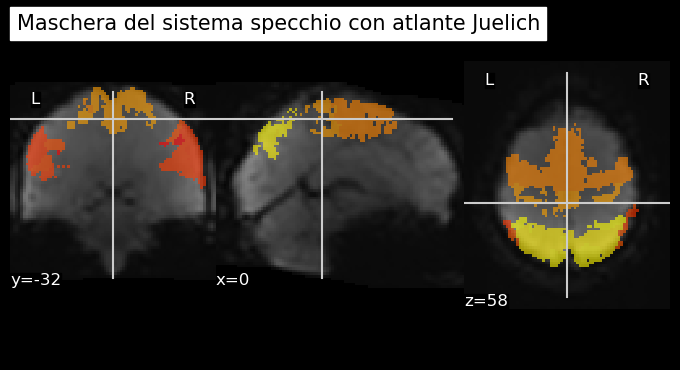

In [18]:
plotting.plot_roi(
    resampled_mask_img,  
    bg_img=fmri_3d,  
    title="Maschera del sistema specchio con atlante Juelich",
    cut_coords=(0, -32, 58),  # Coordinate di taglio
    display_mode='ortho',  # Vista ortogonale
    cmap="autumn",  
    alpha=0.6  # Trasparenza
)
plotting.show()

/opt/anaconda3/envs/neuro_env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/anaconda3/envs/neuro_env/lib/python3.9/site-packages/nilearn/image/resampling.py:756: UserWarning: Casting data from int32 to float32
  return resample_img(
/opt/anaconda3/envs/neuro_env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/anaconda3/envs/neuro_env/lib/python3.9/site-packages/nilearn/image/resampling.py:756: UserWarning: Casting data from int32 to float32
  return resample_img(



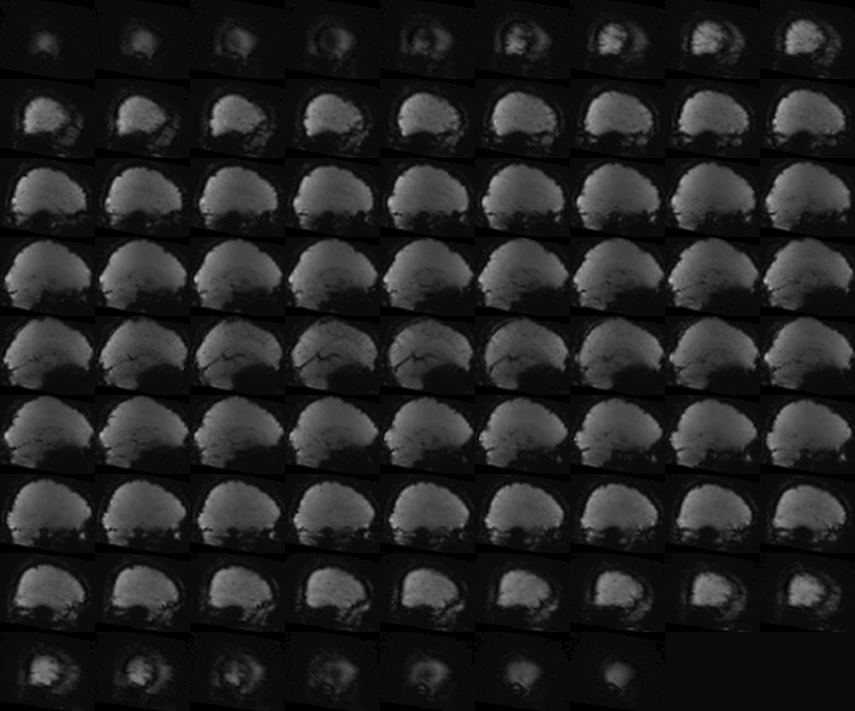
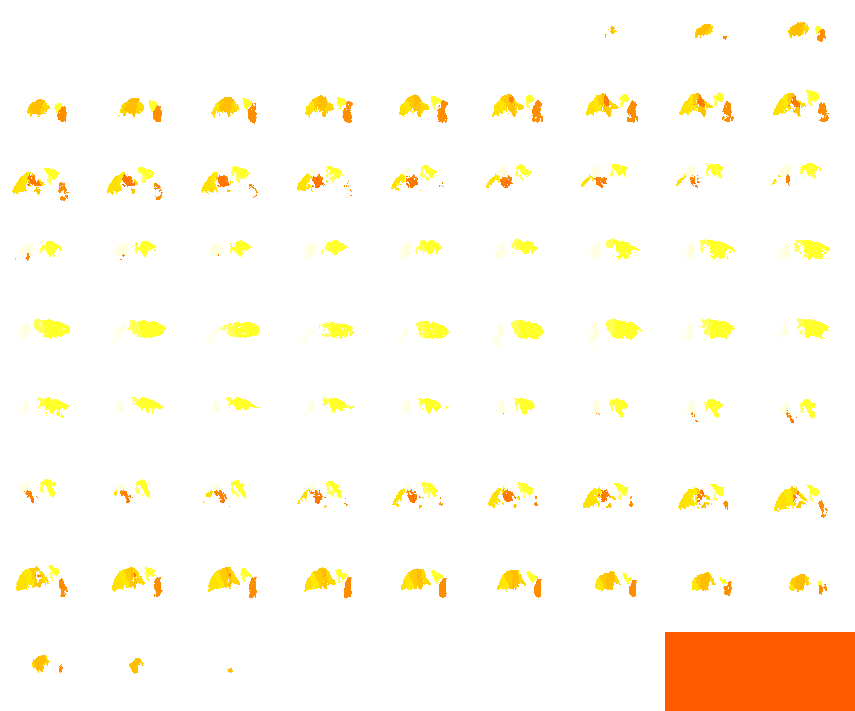

In [19]:
fmri_3d = fmri_img.slicer[..., 0]  # Volume temporale 0

interactive_display = plotting.view_img(
    fmri_3d,  
    threshold=None,  
    title='fMRI con Maschera Sovrapposta',
    cmap='gray',  
    annotate=True
)

interactive_display = plotting.view_img(
    resampled_mask_img,  
    bg_img=fmri_3d,  
    threshold=0.5,  
    title='fMRI + Maschera (Volume Temporale 0)',
    cmap='hot',  
    annotate=True
)

interactive_display

## Calcolo e visualizzazione media varianza segnale Bold per finestre temporali 

In [20]:
window_step = 10  # Passo tra i volumi temporali
selected_volumes = list(range(0, fmri_data.shape[3], window_step)) 
num_windows = len(selected_volumes)

In [21]:
variance_per_window = []
for vol in selected_volumes:
    # Seleziona un singolo volume
    window_data = fmri_data[..., vol]  
    variance_per_window.append(window_data)  

In [22]:
variance_per_window = np.stack(variance_per_window, axis=3)

In [23]:
mean_variance = [np.mean(variance_per_window[..., i]) for i in range(num_windows)]

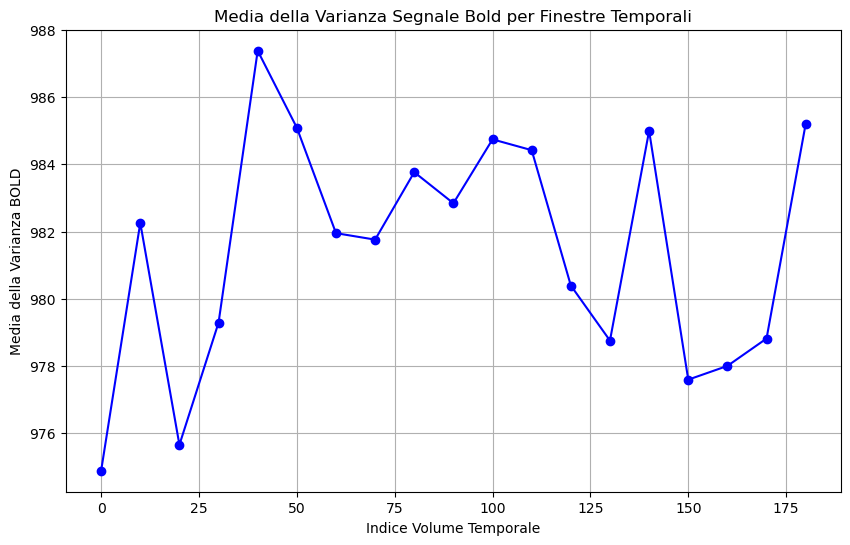

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(selected_volumes, mean_variance, marker='o', linestyle='-', color='b')  # Volumi sull'asse x
plt.title("Media della Varianza Segnale Bold per Finestre Temporali")
plt.xlabel("Indice Volume Temporale")
plt.ylabel("Media della Varianza BOLD")
plt.grid(True)
plt.show()

In [25]:
window_size = 25  # Numero di volumi per finestra
num_windows = fmri_data.shape[3] // window_size  # Numero di finestre

In [26]:
variance_per_window = []

In [27]:
for i in range(num_windows):
    start = i * window_size
    end = start + window_size
    window_data = fmri_data[..., start:end]  
    window_variance = np.var(window_data, axis=3)  
    variance_per_window.append(window_variance)

In [28]:
variance_per_window = np.stack(variance_per_window, axis=3)

In [29]:
mean_variance = [np.mean(variance_per_window[..., i]) for i in range(num_windows)]

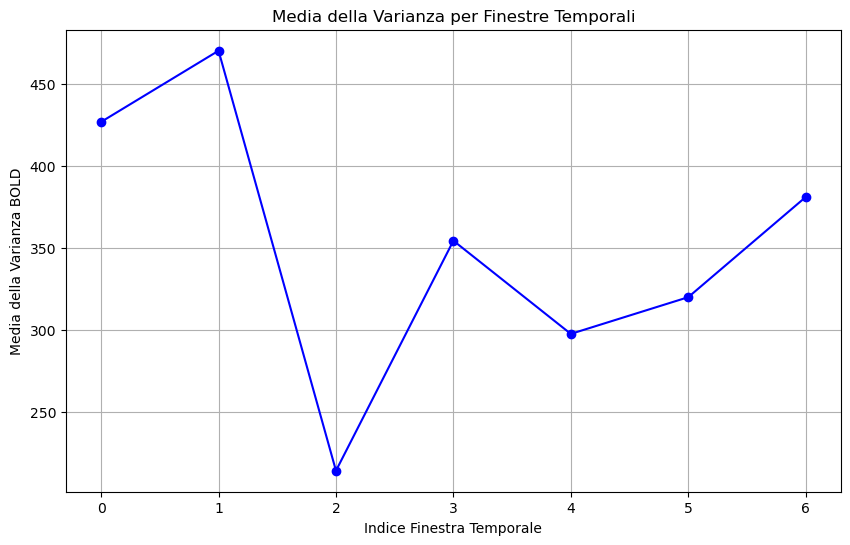

In [30]:
plt.figure(figsize=(10, 6))
plt.plot(range(num_windows), mean_variance, marker='o', linestyle='-', color='b')  # Indici delle finestre sull'asse x
plt.title("Media della Varianza per Finestre Temporali")
plt.xlabel("Indice Finestra Temporale")
plt.ylabel("Media della Varianza BOLD")
plt.grid(True)
plt.show()

In [31]:
normalized_data = (variance_per_window[..., 0] - np.min(variance_per_window[..., 0])) / (
    np.max(variance_per_window[..., 0]) - np.min(variance_per_window[..., 0])
)

In [32]:
num_windows = 6
window_indices = np.linspace(0, variance_per_window.shape[3] - 1, num_windows, dtype=int)
grouped_data = variance_per_window[..., window_indices]


z_slice = grouped_data.shape[2] // 2  
images = [grouped_data[:, :, z_slice, i] for i in range(num_windows)]


images = [(img - np.min(img)) / (np.max(img) - np.min(img)) for img in images]


fig = go.Figure()


for i, img in enumerate(images):
    fig.add_trace(go.Heatmap(
        z=img,
        colorscale='Viridis',
        visible=(i == 0)  
    ))


steps = []
for i in range(num_windows):
    step = dict(
        method="update",
        args=[{"visible": [j == i for j in range(num_windows)]}],
        label=f"Finestra {i+1}"
    )
    steps.append(step)

sliders = [dict(
    active=0,
    currentvalue={"prefix": "Finestra: "},
    pad={"t": 50},
    steps=steps
)]

fig.update_layout(
    title="Segnale BOLD nelle Diverse Finestre Temporali",
    sliders=sliders,
    xaxis_title="Pixel X",
    yaxis_title="Pixel Y"
)

# Esportazione in HTML
fig.write_html("bold_signal_interactive.html")

print("Il grafico è stato salvato come 'bold_signal_interactive.html'. Aprilo nel browser per visualizzarlo.")

Il grafico è stato salvato come 'bold_signal_interactive.html'. Aprilo nel browser per visualizzarlo.


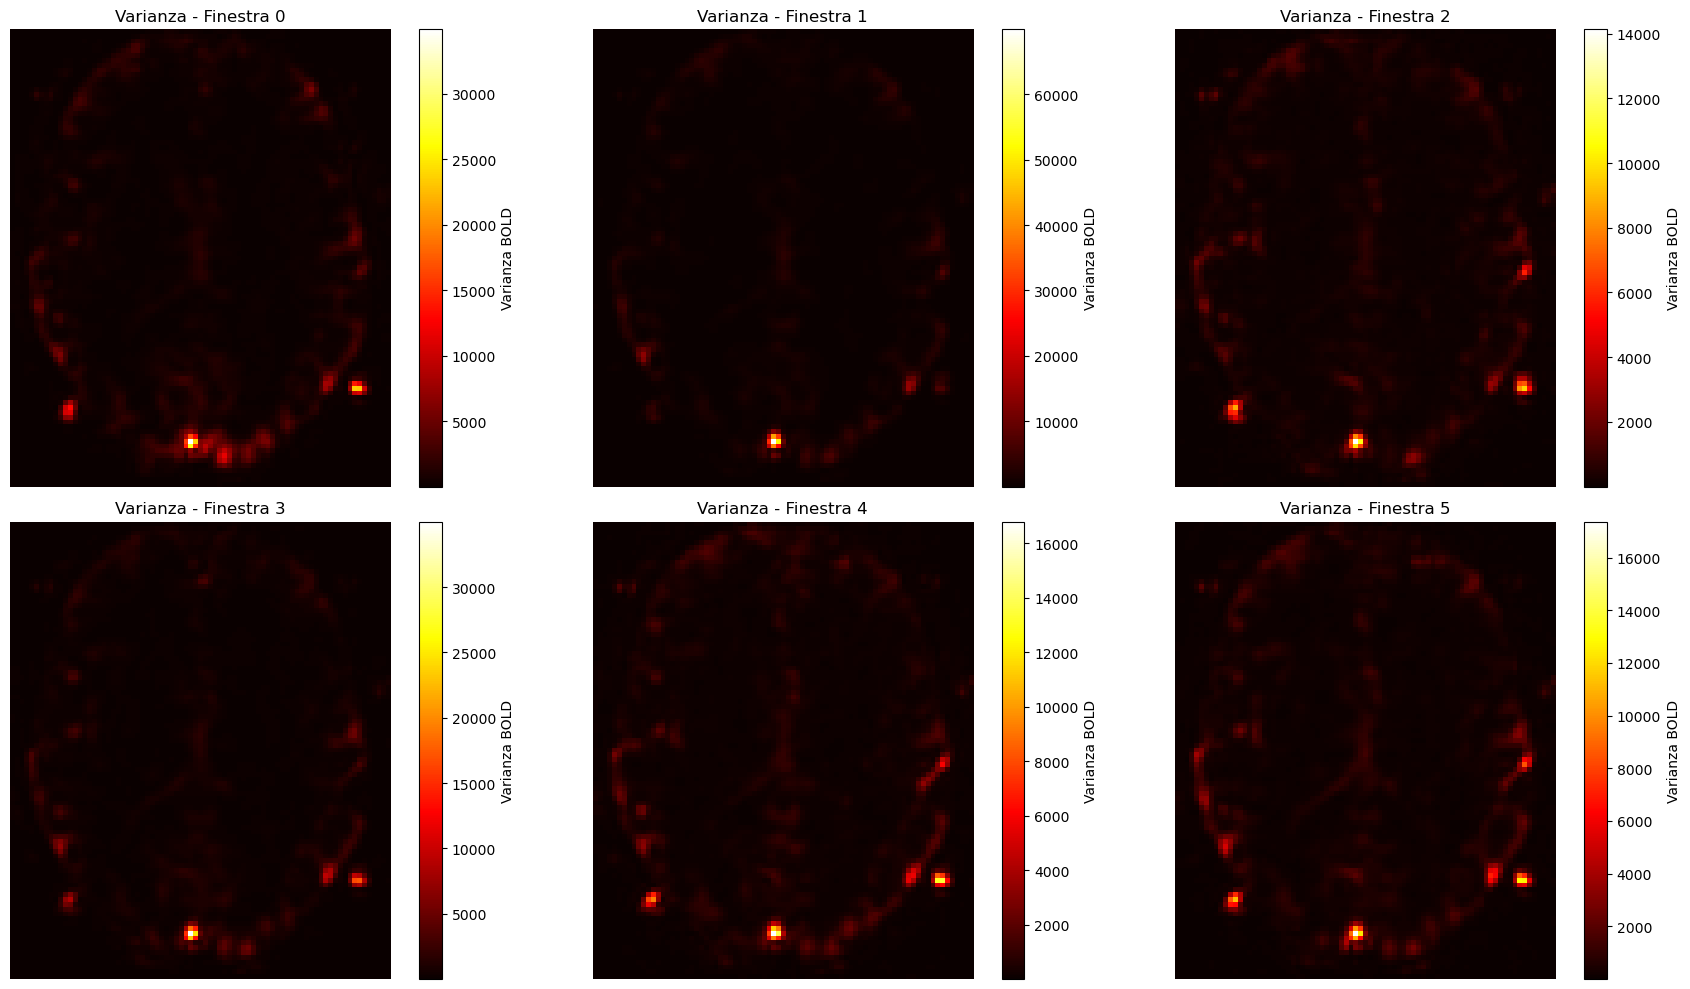

In [33]:
z_center = fmri_data.shape[2] // 2  

plt.figure(figsize=(18, 10))  

for i in range(min(num_windows, 6)):  
    plt.subplot(2, 3, i + 1)  # Griglia 2x3
    plt.imshow(variance_per_window[:, :, z_center, i].T, cmap='hot', origin='lower')
    plt.title(f"Varianza - Finestra {i}")
    plt.colorbar(label="Varianza BOLD")
    plt.axis("off")

plt.tight_layout()
plt.show()

## Serie temporale segnale globale vs maschera

In [34]:
mask = resampled_mask_data.astype(bool)

In [35]:
if not np.any(mask):
    raise ValueError("La maschera è vuota. Controlla i valori in 'resampled_mask_data'.")

In [36]:
global_bold = [np.mean(variance_per_window[..., i]) for i in range(variance_per_window.shape[3])]

In [37]:
import csv

output_csv_path = "/Users/digitalangels/Desktop/data//global_bold_series.csv"

with open(output_csv_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["timepoint", "global_bold"]) 
    for i, value in enumerate(global_bold):
        writer.writerow([i, value])

print(f"Serie temporale salvata in: {output_csv_path}")

Serie temporale salvata in: /Users/digitalangels/Desktop/data//global_bold_series.csv


In [38]:
masked_bold = [np.mean(variance_per_window[..., i][mask]) for i in range(variance_per_window.shape[3])]

In [39]:
output_csv_path = "/Users/digitalangels/Desktop/data//mirror_bold_series.csv"

with open(output_csv_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["timepoint", "global_bold"]) 
    for i, value in enumerate(masked_bold):
        writer.writerow([i, value])

print(f"Serie temporale salvata in: {output_csv_path}")

Serie temporale salvata in: /Users/digitalangels/Desktop/data//mirror_bold_series.csv


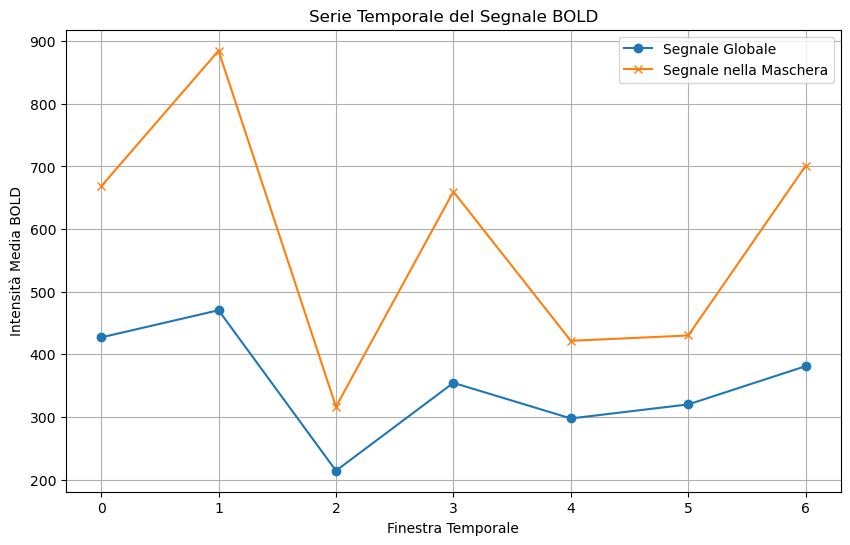

In [40]:
plt.figure(figsize=(10, 6))
plt.plot(global_bold, label='Segnale Globale', marker='o')
plt.plot(masked_bold, label='Segnale nella Maschera', marker='x')
plt.title("Serie Temporale del Segnale BOLD")
plt.xlabel("Finestra Temporale")
plt.ylabel("Intensità Media BOLD")
plt.legend()
plt.grid(True)
plt.show()

In [41]:
adf_global = adfuller(global_bold)
adf_masked = adfuller(masked_bold)

In [42]:
kpss_global = kpss(global_bold, regression='c', nlags="legacy")
kpss_masked = kpss(masked_bold, regression='c', nlags="legacy")

In [43]:
ks_stat, ks_p_value = ks_2samp(global_bold, masked_bold)

In [44]:
anderson_stat, _, _ = anderson_ksamp([global_bold, masked_bold])

In [45]:
t_stat, t_p_value = ttest_ind(global_bold, masked_bold, equal_var=False)

In [46]:
mw_stat, mw_p_value = mannwhitneyu(global_bold, masked_bold, alternative='two-sided')

In [47]:
levene_stat, levene_p_value = levene(global_bold, masked_bold)

In [48]:
bartlett_stat, bartlett_p_value = bartlett(global_bold, masked_bold)

In [49]:
mean_diff = np.mean(masked_bold) - np.mean(global_bold)
pooled_std = np.sqrt((np.std(global_bold, ddof=1)**2 + np.std(masked_bold, ddof=1)**2) / 2)
cohens_d = mean_diff / pooled_std

In [50]:
pearson_corr, pearson_p_value = pearsonr(global_bold, masked_bold)

In [51]:
spearman_corr, spearman_p_value = spearmanr(global_bold, masked_bold)

In [52]:
print(f"T-test: p-value = {t_p_value}")
print(f"Mann-Whitney U test: p-value = {mw_p_value}")

T-test: p-value = 0.02224861106741541
Mann-Whitney U test: p-value = 0.03787878787878788


In [53]:
print(f"ADF Test (Globale): p-value = {adf_global[1]}")
print(f"ADF Test (Maschera): p-value = {adf_masked[1]}")
print(f"KPSS Test (Globale): p-value = {kpss_global[1]}")
print(f"KPSS Test (Maschera): p-value = {kpss_masked[1]}")

ADF Test (Globale): p-value = 0.0997963104095046
ADF Test (Maschera): p-value = 0.045680765770928854
KPSS Test (Globale): p-value = 0.04166666666666662
KPSS Test (Maschera): p-value = 0.04166666666666678


In [54]:
print(f"Correlazione di Pearson: coefficiente = {pearson_corr}, p-value = {pearson_p_value}")
print(f"Correlazione di Spearman: coefficiente = {spearman_corr}, p-value = {spearman_p_value}")

Correlazione di Pearson: coefficiente = 0.9440091770848821, p-value = 0.0013822712698858901
Correlazione di Spearman: coefficiente = 0.9642857142857145, p-value = 0.0004541491691941689


/var/folders/z5/ql92fy5n5md52b43qh02f6km0000gn/T/ipykernel_89255/1869731994.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




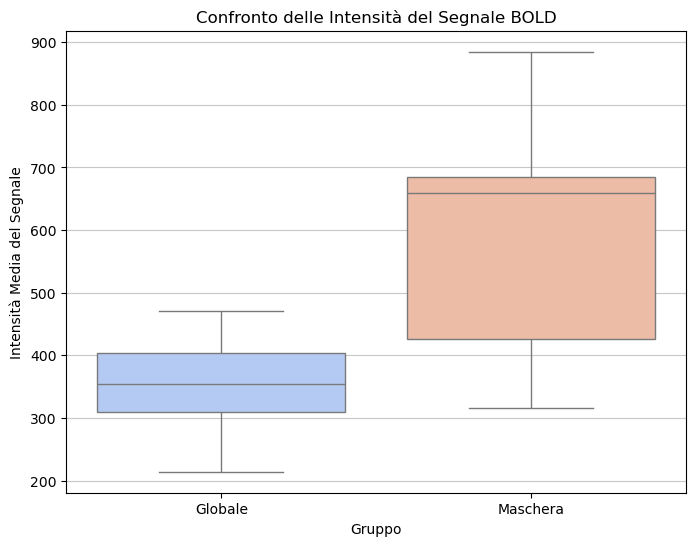

/var/folders/z5/ql92fy5n5md52b43qh02f6km0000gn/T/ipykernel_89255/1869731994.py:17: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




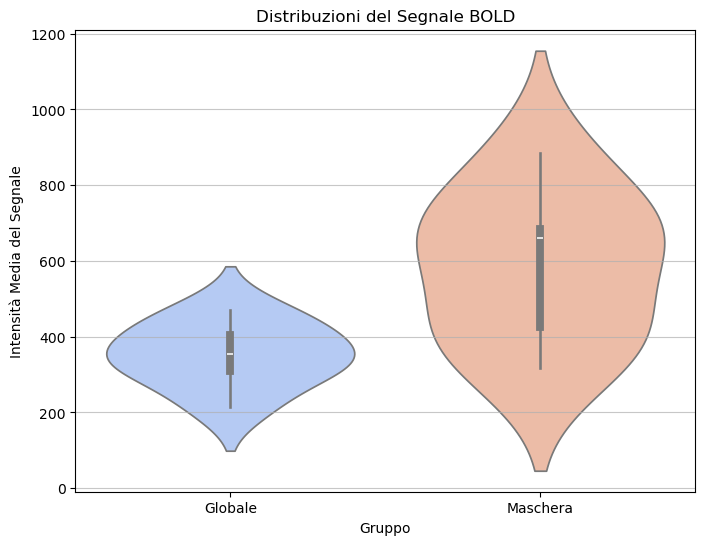

In [55]:
signal_df = pd.DataFrame({
    "Segnale": np.concatenate([global_bold, masked_bold]),
    "Gruppo": ["Globale"] * len(global_bold) + ["Maschera"] * len(masked_bold)
})

# Boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x="Gruppo", y="Segnale", data=signal_df, palette="coolwarm")
plt.title("Confronto delle Intensità del Segnale BOLD")
plt.ylabel("Intensità Media del Segnale")
plt.xlabel("Gruppo")
plt.grid(axis='y', alpha=0.7)
plt.show()

# Violin Plot
plt.figure(figsize=(8, 6))
sns.violinplot(x="Gruppo", y="Segnale", data=signal_df, palette="coolwarm")
plt.title("Distribuzioni del Segnale BOLD")
plt.ylabel("Intensità Media del Segnale")
plt.xlabel("Gruppo")
plt.grid(axis='y', alpha=0.7)
plt.show()

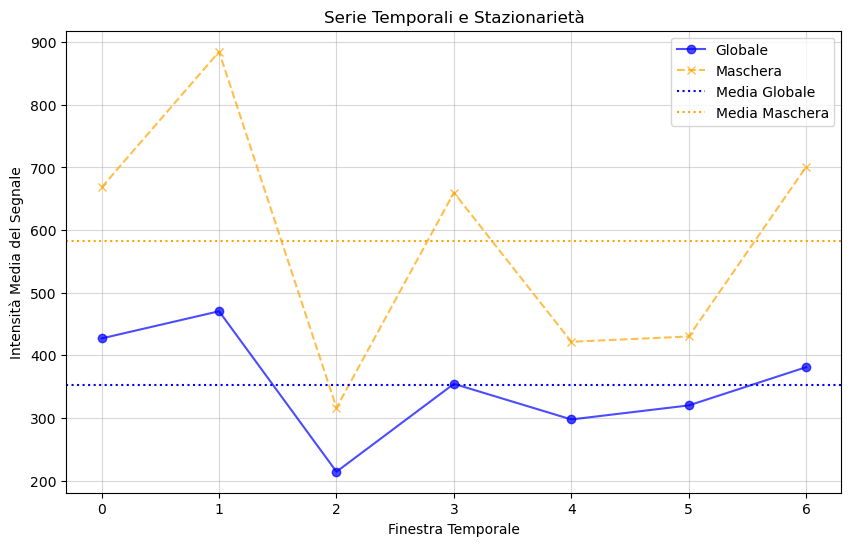

In [56]:
plt.figure(figsize=(10, 6))
plt.plot(global_bold, label="Globale", marker='o', linestyle='-', color='blue', alpha=0.7)
plt.plot(masked_bold, label="Maschera", marker='x', linestyle='--', color='orange', alpha=0.7)

plt.axhline(np.mean(global_bold), color='blue', linestyle=':', label="Media Globale")
plt.axhline(np.mean(masked_bold), color='orange', linestyle=':', label="Media Maschera")

plt.title("Serie Temporali e Stazionarietà")
plt.xlabel("Finestra Temporale")
plt.ylabel("Intensità Media del Segnale")
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()

1. __Differenza delle Medie (T-test e Mann-Whitney U)__

__T-test__: p-value = 0.022 → Esiste una differenza statisticamente significativa nelle medie delle intensità tra la serie globale e quella del sottogruppo (p < 0.05).

__Mann-Whitney U__: p-value = 0.038 → Anche se non assumiamo una distribuzione normale, la differenza nelle distribuzioni è significativa.


__Interpretazione__: Questo indica che le aree cerebrali del sottogruppo si attivano con intensità medie significativamente diverse rispetto all'intero cervello.

2. __Stazionarietà delle Serie Temporali (ADF e KPSS)__

__ADF Test (Globale)__: p-value = 0.099 → La serie globale non è chiaramente stazionaria.

__ADF Test (Maschera)__: p-value = 0.046 → La serie nella maschera è marginalmente stazionaria.

__KPSS Test (Globale)__: p-value = 0.042 → La serie globale non è pienamente stazionaria.

__KPSS Test (Maschera)__: p-value = 0.042 → La serie nella maschera non è pienamente stazionaria.

__Interpretazione__: Entrambe le serie mostrano una parziale stazionarietà, con la serie della maschera leggermente più stabile. Questo suggerisce che il segnale del sottogruppo delle aree potrebbe avere una struttura temporale più coerente.


3. __Correlazione tra le Serie Temporali__

__Correlazione di Pearson__: Coefficiente = 0.944, p-value = 0.001 → Forte correlazione lineare tra le due serie.

__Correlazione di Spearman__: Coefficiente = 0.964, p-value = 0.00045 → Forte correlazione monotona tra le due serie.

__Interpretazione__: Le due serie temporali mostrano un forte legame, suggerendo che l'attivazione delle aree del 
sottogruppo segue un pattern simile a quello globale, pur avendo differenze di intensità.

__Conclusioni Generali__

__Differenze di Intensità__: Le aree del sottogruppo si attivano in modo significativamente diverso rispetto all'intero cervello, con differenze medie significative.

__Stazionarietà__: Entrambe le serie mostrano comportamenti non completamente stazionari, ma il sottogruppo appare leggermente più stabile.

__Somiglianza Temporale__: Nonostante le differenze di intensità, le due serie sono fortemente correlate, suggerendo una similarità nel pattern generale di attivazione.


## Serie temporale per regioni maschera 

In [57]:
atlas = fetch_atlas_juelich("maxprob-thr0-1mm")
labels = atlas['labels']


label_dict = {i: labels[i] for i in range(len(labels)) if labels[i] != 'Background'}

regions = np.unique(resampled_mask_data[resampled_mask_data > 0])  
regions_with_labels = {region: label_dict.get(region, f"Region {int(region)}") for region in regions}

print("Mapping delle regioni (valore -> label):")
for region, label in regions_with_labels.items():
    print(f"{region} -> {label}")

Mapping delle regioni (valore -> label):
4 -> GM Anterior intra-parietal sulcus hIP1
5 -> GM Anterior intra-parietal sulcus hIP2
6 -> GM Anterior intra-parietal sulcus hIP3
7 -> GM Broca's area BA44
14 -> GM Inferior parietal lobule PF
15 -> GM Inferior parietal lobule PFcm
16 -> GM Inferior parietal lobule PFm
17 -> GM Inferior parietal lobule PFop
18 -> GM Inferior parietal lobule PFt
19 -> GM Inferior parietal lobule PGp
20 -> GM Inferior parietal lobule Pga
27 -> GM Premotor cortex BA6
31 -> GM Primary motor cortex BA4a
32 -> GM Primary motor cortex BA4p
44 -> GM Superior parietal lobule 7A
45 -> GM Superior parietal lobule 7M
46 -> GM Superior parietal lobule 7P
47 -> GM Superior parietal lobule 7PC


In [58]:
region_series = {}

for region, label in regions_with_labels.items():
    
    region_mask = resampled_mask_data == region  
    series_for_region = []
    
    for t in range(variance_per_window.shape[3]):  
        mean_value = np.mean(variance_per_window[..., t][region_mask])  
        series_for_region.append(mean_value)
    
    region_series[label] = series_for_region

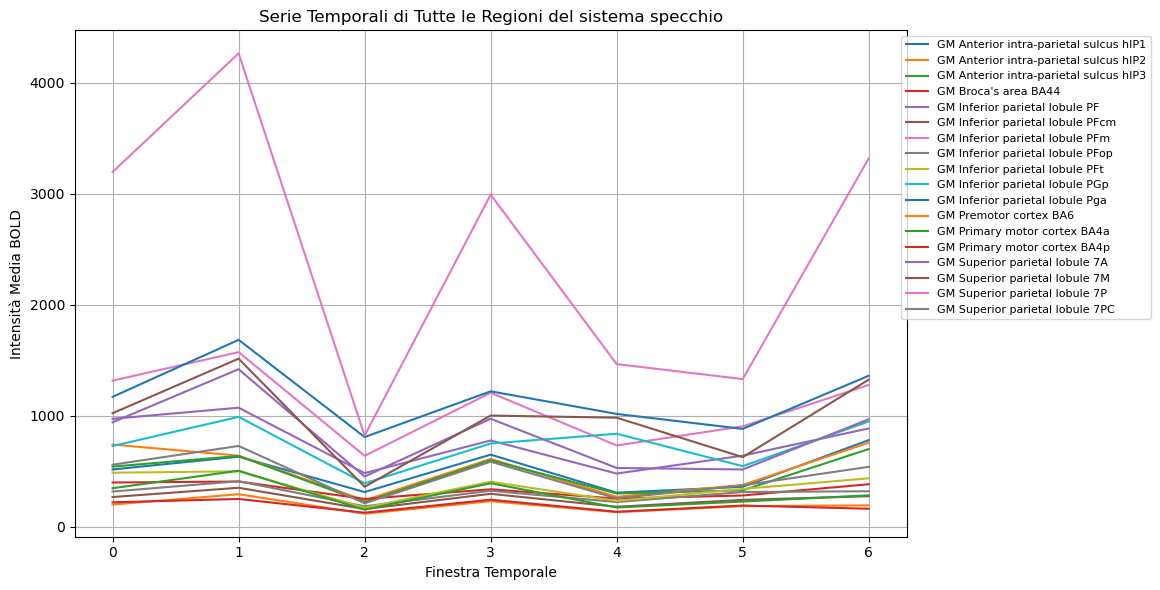

In [59]:
plt.figure(figsize=(12, 6))

for region, label in regions_with_labels.items():
    plt.plot(region_series[label], label=label)  

plt.title("Serie Temporali di Tutte le Regioni del sistema specchio")
plt.xlabel("Finestra Temporale")
plt.ylabel("Intensità Media BOLD")
plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1), fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()

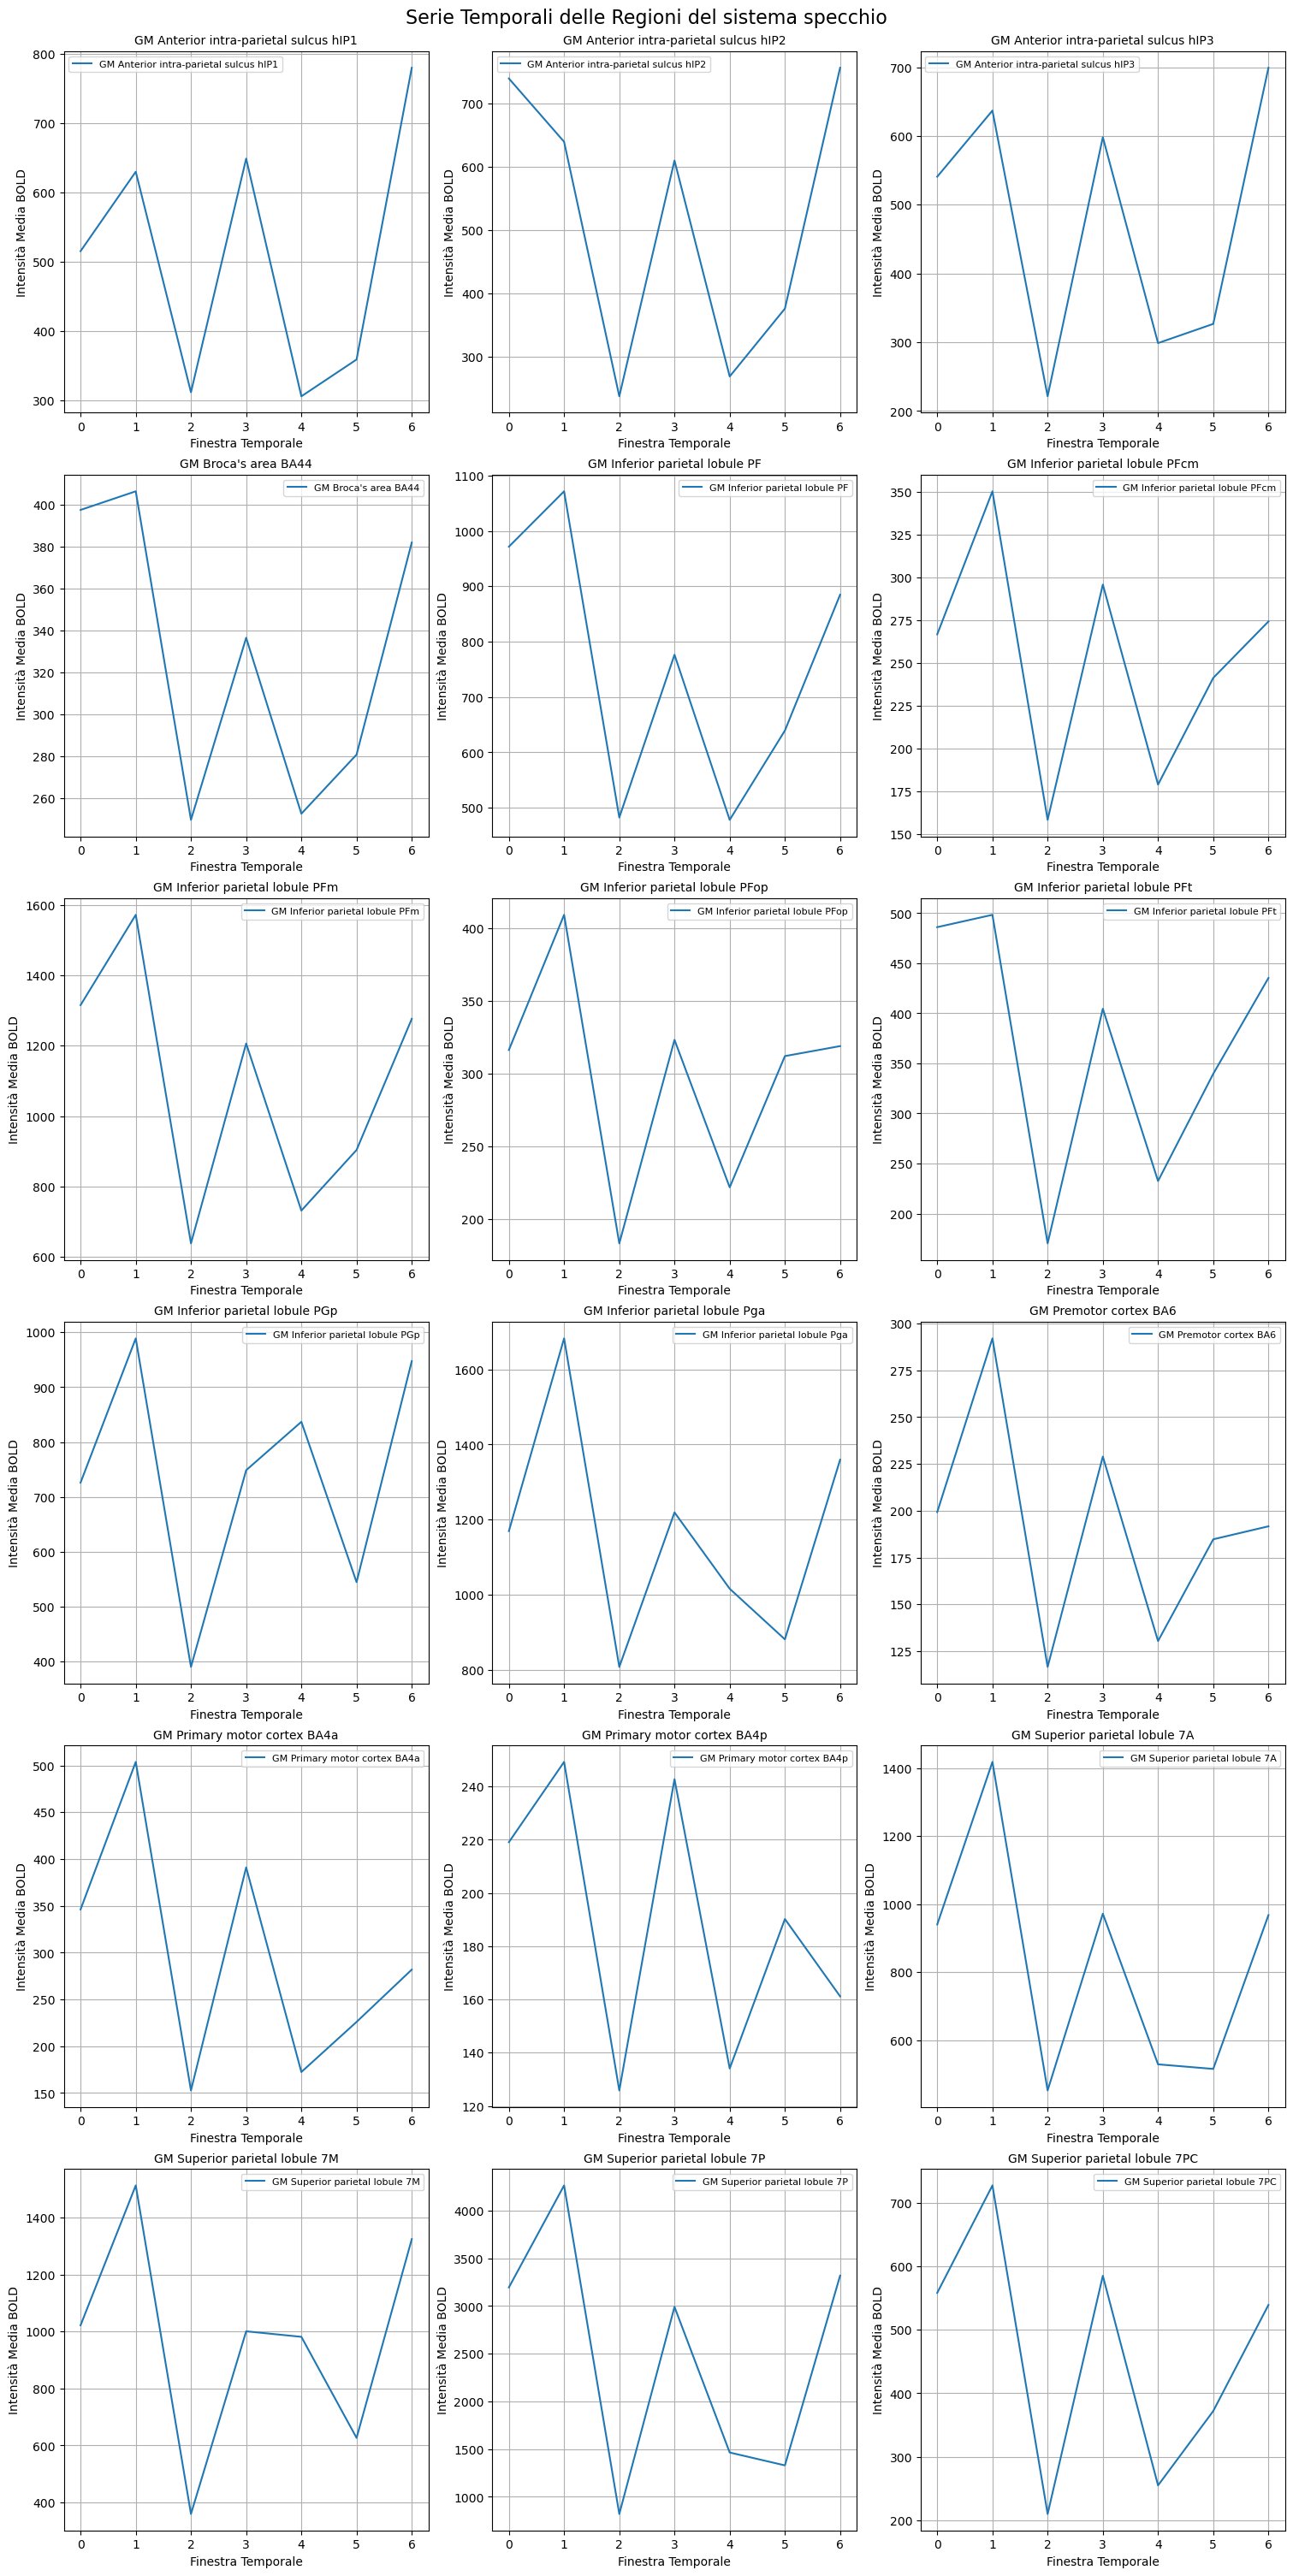

In [60]:
num_regions = len(regions_with_labels)
cols = 3
rows = int(np.ceil(num_regions / cols))

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows), constrained_layout=True)
axes = axes.flatten()

for idx, (region, label) in enumerate(regions_with_labels.items()):
    ax = axes[idx]
    ax.plot(region_series[label], label=label)
    ax.set_title(label, fontsize=10)
    ax.set_xlabel("Finestra Temporale")
    ax.set_ylabel("Intensità Media BOLD")
    ax.grid(True)
    ax.legend(fontsize=8)

for ax in axes[num_regions:]:
    ax.axis('off')

plt.suptitle("Serie Temporali delle Regioni del sistema specchio", fontsize=16)
plt.show()

In [61]:
region_activation = {
    label: {
        "max": max(series),
        "mean": sum(series) / len(series)
    }
    for label, series in region_series.items()
}

sorted_regions = sorted(region_activation.items(), key=lambda x: x[1]['mean'], reverse=True)

print("Top 3 regioni con maggiore attivazione media:")
for region, values in sorted_regions[:3]:
    print(f"Regione: {region} - Attivazione Media: {values['mean']:.2f}, Attivazione Massima: {values['max']:.2f}")

Top 3 regioni con maggiore attivazione media:
Regione: GM Superior parietal lobule 7P - Attivazione Media: 2483.07, Attivazione Massima: 4263.86
Regione: GM Inferior parietal lobule Pga - Attivazione Media: 1161.99, Attivazione Massima: 1682.86
Regione: GM Inferior parietal lobule PFm - Attivazione Media: 1091.89, Attivazione Massima: 1572.31


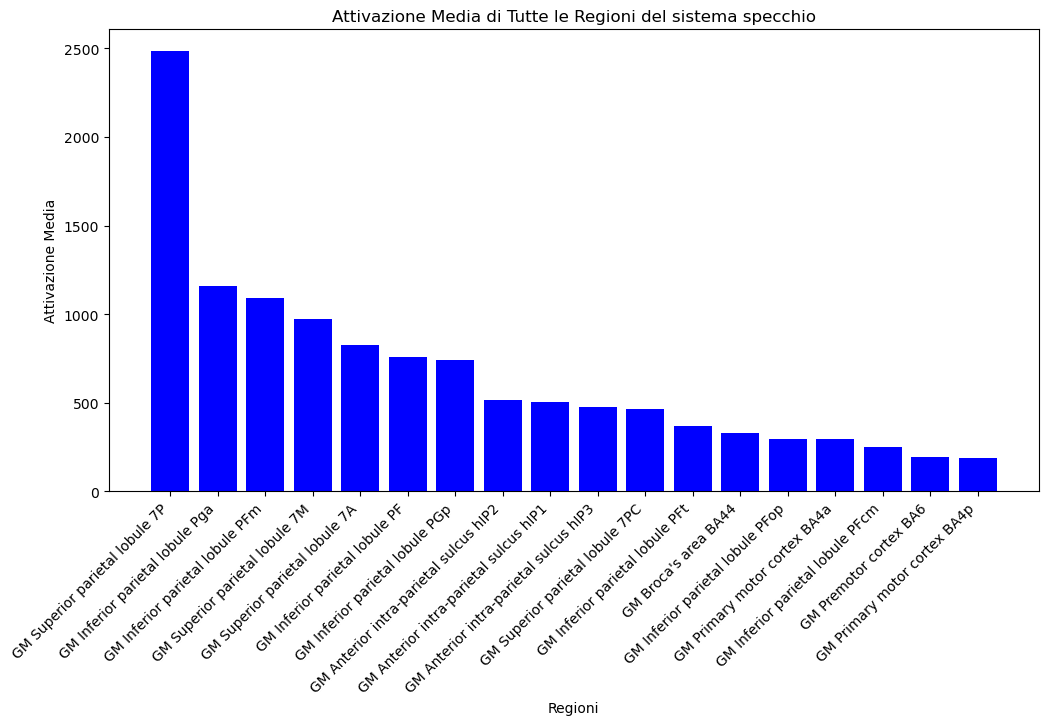

In [62]:
regions_sorted = [region for region, _ in sorted_regions]
means_sorted = [values['mean'] for _, values in sorted_regions]

plt.figure(figsize=(12, 6))
plt.bar(regions_sorted, means_sorted, color="blue")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Regioni")
plt.ylabel("Attivazione Media")
plt.title("Attivazione Media di Tutte le Regioni del sistema specchio")
plt.show()

## Correlazioni regioni cerebrali maschera

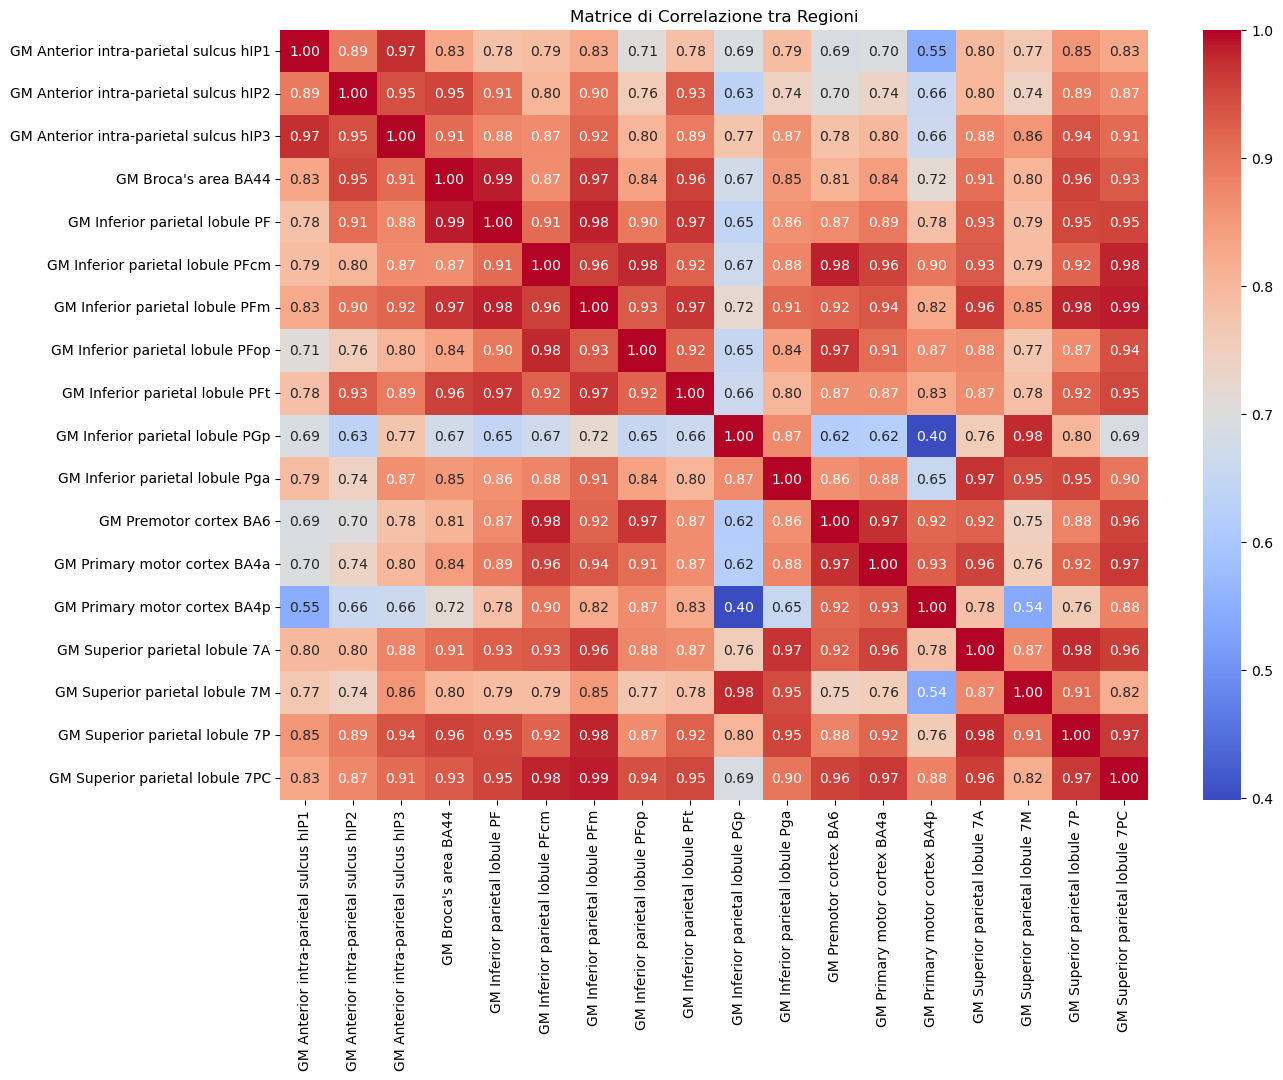

In [63]:
data = pd.DataFrame(region_series)

correlation_matrix = data.corr()

plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Matrice di Correlazione tra Regioni")
plt.show()

In [64]:
output_csv_path = "/Users/digitalangels/Desktop/data/correlation_matrix.csv"
correlation_matrix.to_csv(output_csv_path, index=True)
print(f"Matrice di correlazione salvata in: {output_csv_path}")

Matrice di correlazione salvata in: /Users/digitalangels/Desktop/data/correlation_matrix.csv


In [65]:
correlations = correlation_matrix.values[np.triu_indices_from(correlation_matrix, k=1)]

mean_correlation = np.mean(correlations)
std_correlation = np.std(correlations)

print(f"Media delle correlazioni: {mean_correlation:.2f}")
print(f"Deviazione standard delle correlazioni: {std_correlation:.2f}")

Media delle correlazioni: 0.85
Deviazione standard delle correlazioni: 0.11


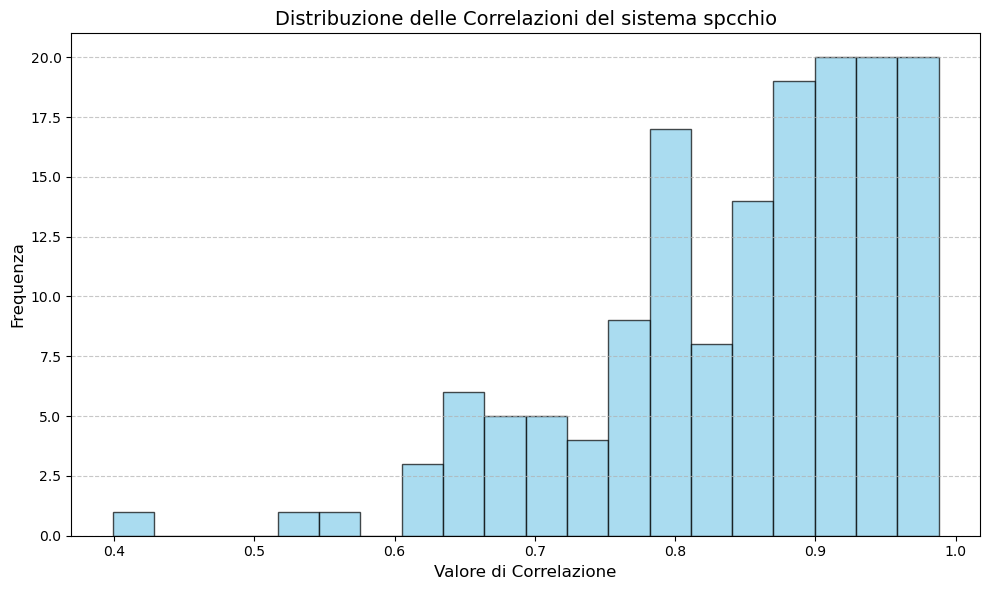

In [66]:
plt.figure(figsize=(10, 6))
plt.hist(correlations, bins=20, color="skyblue", edgecolor="black", alpha=0.7)
plt.title("Distribuzione delle Correlazioni del sistema spcchio", fontsize=14)
plt.xlabel("Valore di Correlazione", fontsize=12)
plt.ylabel("Frequenza", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

In [67]:
high_correlation = correlations[correlations >= 0.8]
medium_correlation = correlations[(correlations >= 0.6) & (correlations < 0.8)]
low_correlation = correlations[correlations < 0.6]

print(f"Numero di correlazioni alte (>= 0.8): {len(high_correlation)}")
print(f"Numero di correlazioni medie (0.6 <= correlazione < 0.8): {len(medium_correlation)}")
print(f"Numero di correlazioni basse (< 0.6): {len(low_correlation)}")

print("\nValori di correlazioni alte:")
print(high_correlation)

print("\nValori di correlazioni medie:")
print(medium_correlation)

print("\nValori di correlazioni basse:")
print(low_correlation)

Numero di correlazioni alte (>= 0.8): 107
Numero di correlazioni medie (0.6 <= correlazione < 0.8): 43
Numero di correlazioni basse (< 0.6): 3

Valori di correlazioni alte:
[0.89404553 0.97272186 0.82883924 0.82546828 0.85494661 0.82784274
 0.94520269 0.95467602 0.91076766 0.80426981 0.90218872 0.9314653
 0.89358233 0.87377463 0.91308369 0.87726736 0.87064944 0.91785733
 0.80455723 0.88972108 0.86500814 0.87792647 0.85652017 0.94029924
 0.91237502 0.98733023 0.86802573 0.97020143 0.83642003 0.95812753
 0.85055743 0.80660543 0.84382865 0.90662419 0.80412009 0.95614309
 0.93112507 0.91178911 0.98490108 0.89534455 0.96789304 0.86176856
 0.87280773 0.89225193 0.92655279 0.95205635 0.95446649 0.95829521
 0.97895061 0.92374675 0.87864733 0.98378299 0.95739739 0.89721096
 0.93096552 0.92137279 0.9835467  0.92997755 0.96800462 0.91377201
 0.92219494 0.93597964 0.82353475 0.96332293 0.84892656 0.98182632
 0.98790977 0.92203429 0.83625536 0.96769867 0.90860599 0.87005921
 0.87572072 0.87007711 0

In [68]:
# Array dei valori di correlazione alta
high_correlation_values = [
    0.89404553, 0.97272186, 0.82883924, 0.82546828, 0.85494661, 0.82784274,
    0.94520269, 0.95467602, 0.91076766, 0.80426981, 0.90218872, 0.9314653,
    0.89358233, 0.87377463, 0.91308369, 0.87726736, 0.87064944, 0.91785733,
    0.80455723, 0.88972108, 0.86500814, 0.87792647, 0.85652017, 0.94029924,
    0.91237502, 0.98733023, 0.86802573, 0.97020143, 0.83642003, 0.95812753,
    0.85055743, 0.80660543, 0.84382865, 0.90662419, 0.80412009, 0.95614309,
    0.93112507, 0.91178911, 0.98490108, 0.89534455, 0.96789304, 0.86176856,
    0.87280773, 0.89225193, 0.92655279, 0.95205635, 0.95446649, 0.95829521,
    0.97895061, 0.92374675, 0.87864733, 0.98378299, 0.95739739, 0.89721096,
    0.93096552, 0.92137279, 0.9835467, 0.92997755, 0.96800462, 0.91377201,
    0.92219494, 0.93597964, 0.82353475, 0.96332293, 0.84892656, 0.98182632,
    0.98790977, 0.92203429, 0.83625536, 0.96769867, 0.90860599, 0.87005921,
    0.87572072, 0.87007711, 0.94320405, 0.80383608, 0.86686995, 0.8663305,
    0.82583833, 0.86796894, 0.92431566, 0.95156516, 0.87128551, 0.97661771,
    0.80476436, 0.86495191, 0.87943957, 0.97037921, 0.94825212, 0.95365678,
    0.89819524, 0.97370487, 0.91736042, 0.92325422, 0.88037922, 0.95557319,
    0.92520611, 0.95658425, 0.91787197, 0.96581473, 0.88330561, 0.87358448,
    0.97805558, 0.96064854, 0.90844783, 0.81715146, 0.9668109
]

top_3_correlation = sorted(high_correlation_values, reverse=True)[:3]

print("Top 3 valori di correlazione:")
for i, value in enumerate(top_3_correlation, 1):
    print(f"{i}. {value:.2f}")

Top 3 valori di correlazione:
1. 0.99
2. 0.99
3. 0.98


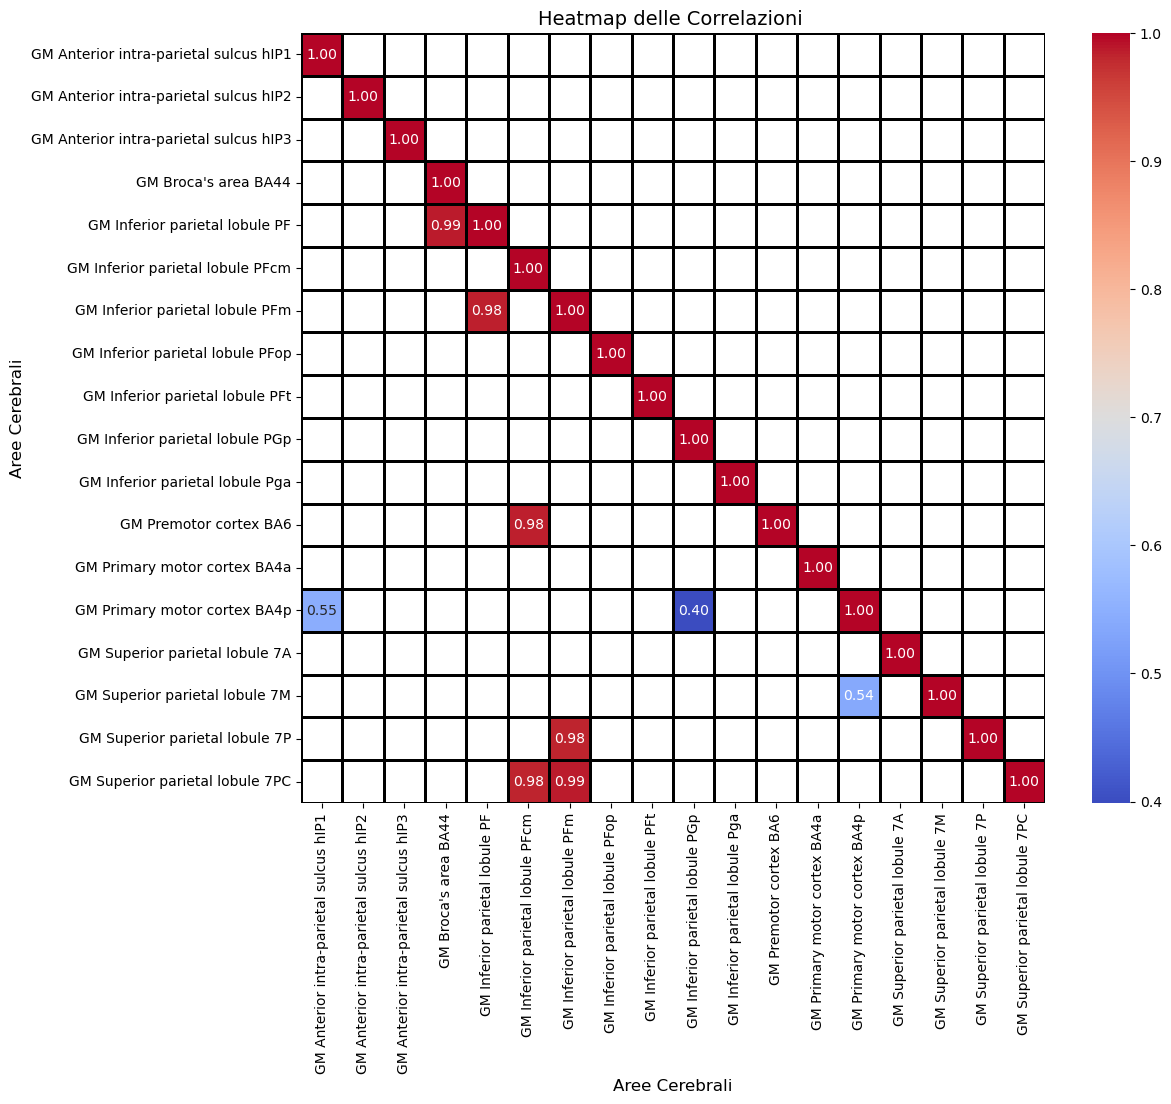

In [69]:
correlation_matrix = data.corr()

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)

filtered_matrix = correlation_matrix.where((correlation_matrix >= 0.98) | (correlation_matrix <= 0.56))

filtered_matrix = np.ma.masked_where(mask, filtered_matrix)

plt.figure(figsize=(12, 10))
sns.heatmap(filtered_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, linewidths=1, linecolor='black', mask=mask, xticklabels=correlation_matrix.columns, yticklabels=correlation_matrix.columns)

plt.title("Heatmap delle Correlazioni ", fontsize=14)
plt.xlabel("Aree Cerebrali", fontsize=12)
plt.ylabel("Aree Cerebrali", fontsize=12)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(rotation=0, fontsize=10)

plt.show()

In [70]:
high_correlation_indices = np.where(correlation_matrix >= 0.98)
low_correlation_indices = np.where(correlation_matrix <= 0.55)

high_correlation_pairs = []
low_correlation_pairs = []

for i, j in zip(*high_correlation_indices):
    if i < j:  # Solo la parte superiore (escludendo i duplicati)
        high_correlation_pairs.append((data.columns[i], data.columns[j], correlation_matrix.iloc[i, j]))

for i, j in zip(*low_correlation_indices):
    if i < j:  # Solo la parte superiore (escludendo i duplicati)
        low_correlation_pairs.append((data.columns[i], data.columns[j], correlation_matrix.iloc[i, j]))

# Mostra i risultati verbali
print("Coppie di regioni con correlazione >= 0.98:")
for pair in high_correlation_pairs:
    print(f"{pair[0]} e {pair[1]}: correlazione = {pair[2]:.2f}")

print("\nCoppie di regioni con correlazione <= 0.55:")
for pair in low_correlation_pairs:
    print(f"{pair[0]} e {pair[1]}: correlazione = {pair[2]:.2f}")

Coppie di regioni con correlazione >= 0.98:
GM Broca's area BA44 e GM Inferior parietal lobule PF: correlazione = 0.99
GM Inferior parietal lobule PF e GM Inferior parietal lobule PFm: correlazione = 0.98
GM Inferior parietal lobule PFcm e GM Premotor cortex BA6: correlazione = 0.98
GM Inferior parietal lobule PFcm e GM Superior parietal lobule 7PC: correlazione = 0.98
GM Inferior parietal lobule PFm e GM Superior parietal lobule 7P: correlazione = 0.98
GM Inferior parietal lobule PFm e GM Superior parietal lobule 7PC: correlazione = 0.99

Coppie di regioni con correlazione <= 0.55:
GM Anterior intra-parietal sulcus hIP1 e GM Primary motor cortex BA4p: correlazione = 0.55
GM Inferior parietal lobule PGp e GM Primary motor cortex BA4p: correlazione = 0.40
GM Primary motor cortex BA4p e GM Superior parietal lobule 7M: correlazione = 0.54


## Grafo maschera 

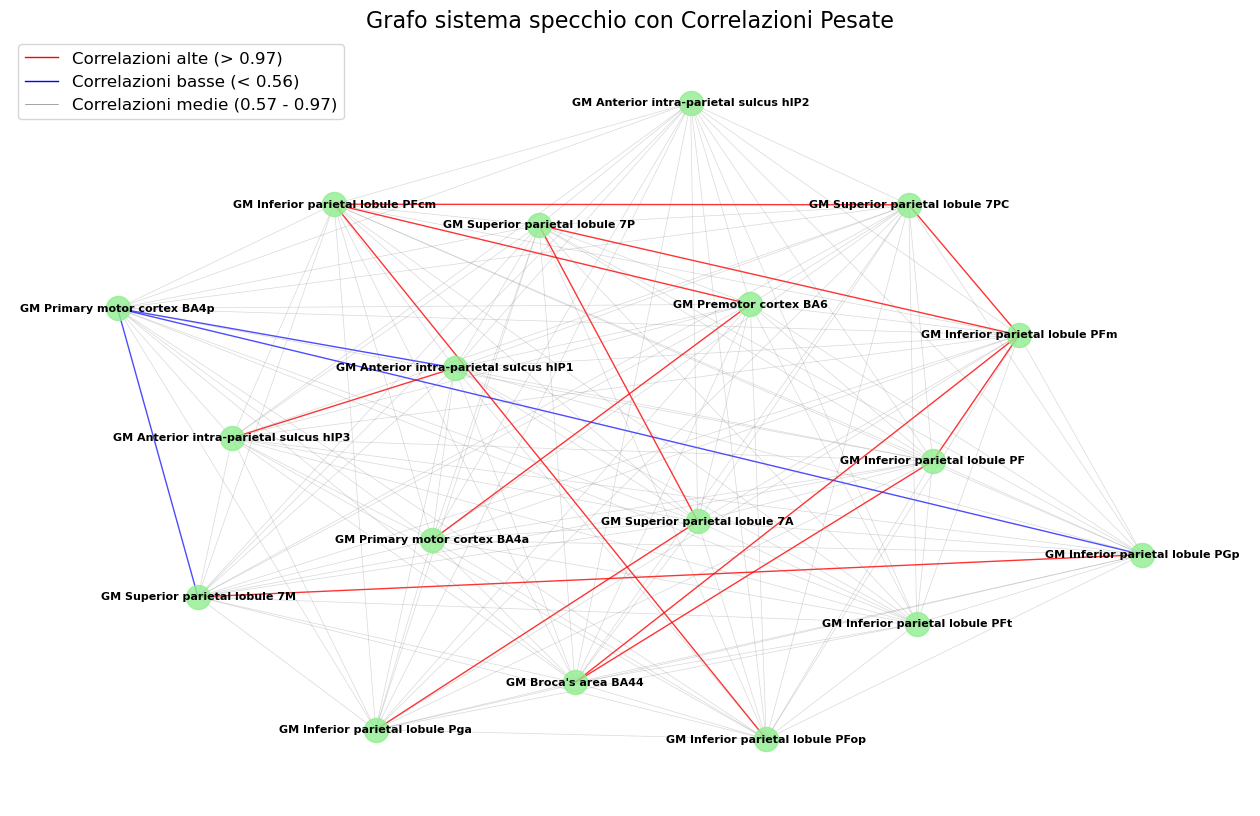

In [71]:
G = nx.Graph()

for area in correlation_matrix.columns:
    G.add_node(area)

for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        correlation_value = correlation_matrix.iloc[i, j]
        region1 = correlation_matrix.columns[i]
        region2 = correlation_matrix.columns[j]
        G.add_edge(region1, region2, weight=correlation_value)

pos = nx.spring_layout(G, seed=42, k=0.15)  

plt.figure(figsize=(16, 10))

nx.draw_networkx_nodes(G, pos, node_size=300, node_color='lightgreen', alpha=0.8)

high_corr_edges = []
low_corr_edges = []
medium_corr_edges = []

high_corr_weights = []
low_corr_weights = []
medium_corr_weights = []

for edge in G.edges(data=True):
    weight = edge[2]['weight']
    if weight > 0.97:
        high_corr_edges.append(edge)
        high_corr_weights.append(weight)
    elif weight < 0.56:
        low_corr_edges.append(edge)
        low_corr_weights.append(weight)
    else:
        medium_corr_edges.append(edge)
        medium_corr_weights.append(weight)

nx.draw_networkx_edges(G, pos, edgelist=low_corr_edges, width=1, alpha=0.7, edge_color='blue')

nx.draw_networkx_edges(G, pos, edgelist=high_corr_edges, width=1, alpha=0.8, edge_color='red')

nx.draw_networkx_edges(G, pos, edgelist=medium_corr_edges, width=0.5, alpha=0.3, edge_color='gray')

nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold', font_color='black')

legend_elements = [
    Line2D([0], [0], color='red', lw=1, label='Correlazioni alte (> 0.97)'),
    Line2D([0], [0], color='blue', lw=1, label='Correlazioni basse (< 0.56)'),
    Line2D([0], [0], color='gray', lw=0.5, label='Correlazioni medie (0.57 - 0.97)'),
]

plt.legend(handles=legend_elements, loc='upper left', fontsize=12)

plt.title("Grafo sistema specchio con Correlazioni Pesate", fontsize=16)

plt.axis('off')

plt.show()

In [72]:
areas_in_mask = np.unique(resampled_mask_data[resampled_mask_data > 0])

coordinates_3d = {}

affine = juelich_atlas_img.affine

for area in areas_in_mask:
    
    area_voxels = np.where(resampled_mask_data == area)
    
    x_voxels, y_voxels, z_voxels = area_voxels

    coordinates_3d_area = np.vstack((x_voxels, y_voxels, z_voxels, np.ones_like(x_voxels)))
    real_coordinates = np.dot(affine, coordinates_3d_area)[:3].T  
    
    mean_coordinates = np.mean(real_coordinates, axis=0)
    
    coordinates_3d[area] = mean_coordinates

for area, coord in coordinates_3d.items():
    print(f"Area {area}: Coordinate 3D = {coord}")

Area 4: Coordinate 3D = [-48.0738342  -94.31606218 -17.96373057]
Area 5: Coordinate 3D = [-44.19390582 -89.8365651  -15.39889197]
Area 6: Coordinate 3D = [-52.99664992 -95.64489112 -14.08877722]
Area 7: Coordinate 3D = [-48.19812383 -63.89193246 -27.71369606]
Area 14: Coordinate 3D = [-51.82032478 -88.06914615 -20.51650079]
Area 15: Coordinate 3D = [-51.01643836 -87.69726027 -25.16712329]
Area 16: Coordinate 3D = [-59.88517442 -93.7994186  -17.92078488]
Area 17: Coordinate 3D = [-50.68587361 -81.69702602 -23.70817844]
Area 18: Coordinate 3D = [-53.11292346 -82.48933501 -18.00376412]
Area 19: Coordinate 3D = [ -52.92454998 -106.18690157  -21.8617388 ]
Area 20: Coordinate 3D = [-57.40584246 -98.75273865 -19.00417319]
Area 27: Coordinate 3D = [-52.35521628 -73.02249364  -6.98452926]
Area 31: Coordinate 3D = [-52.13435115 -84.23816794  -5.34961832]
Area 32: Coordinate 3D = [-50.72327965 -80.61639824 -13.06881406]
Area 44: Coordinate 3D = [ -50.61768489 -100.24790997   -6.99131833]
Area 45:

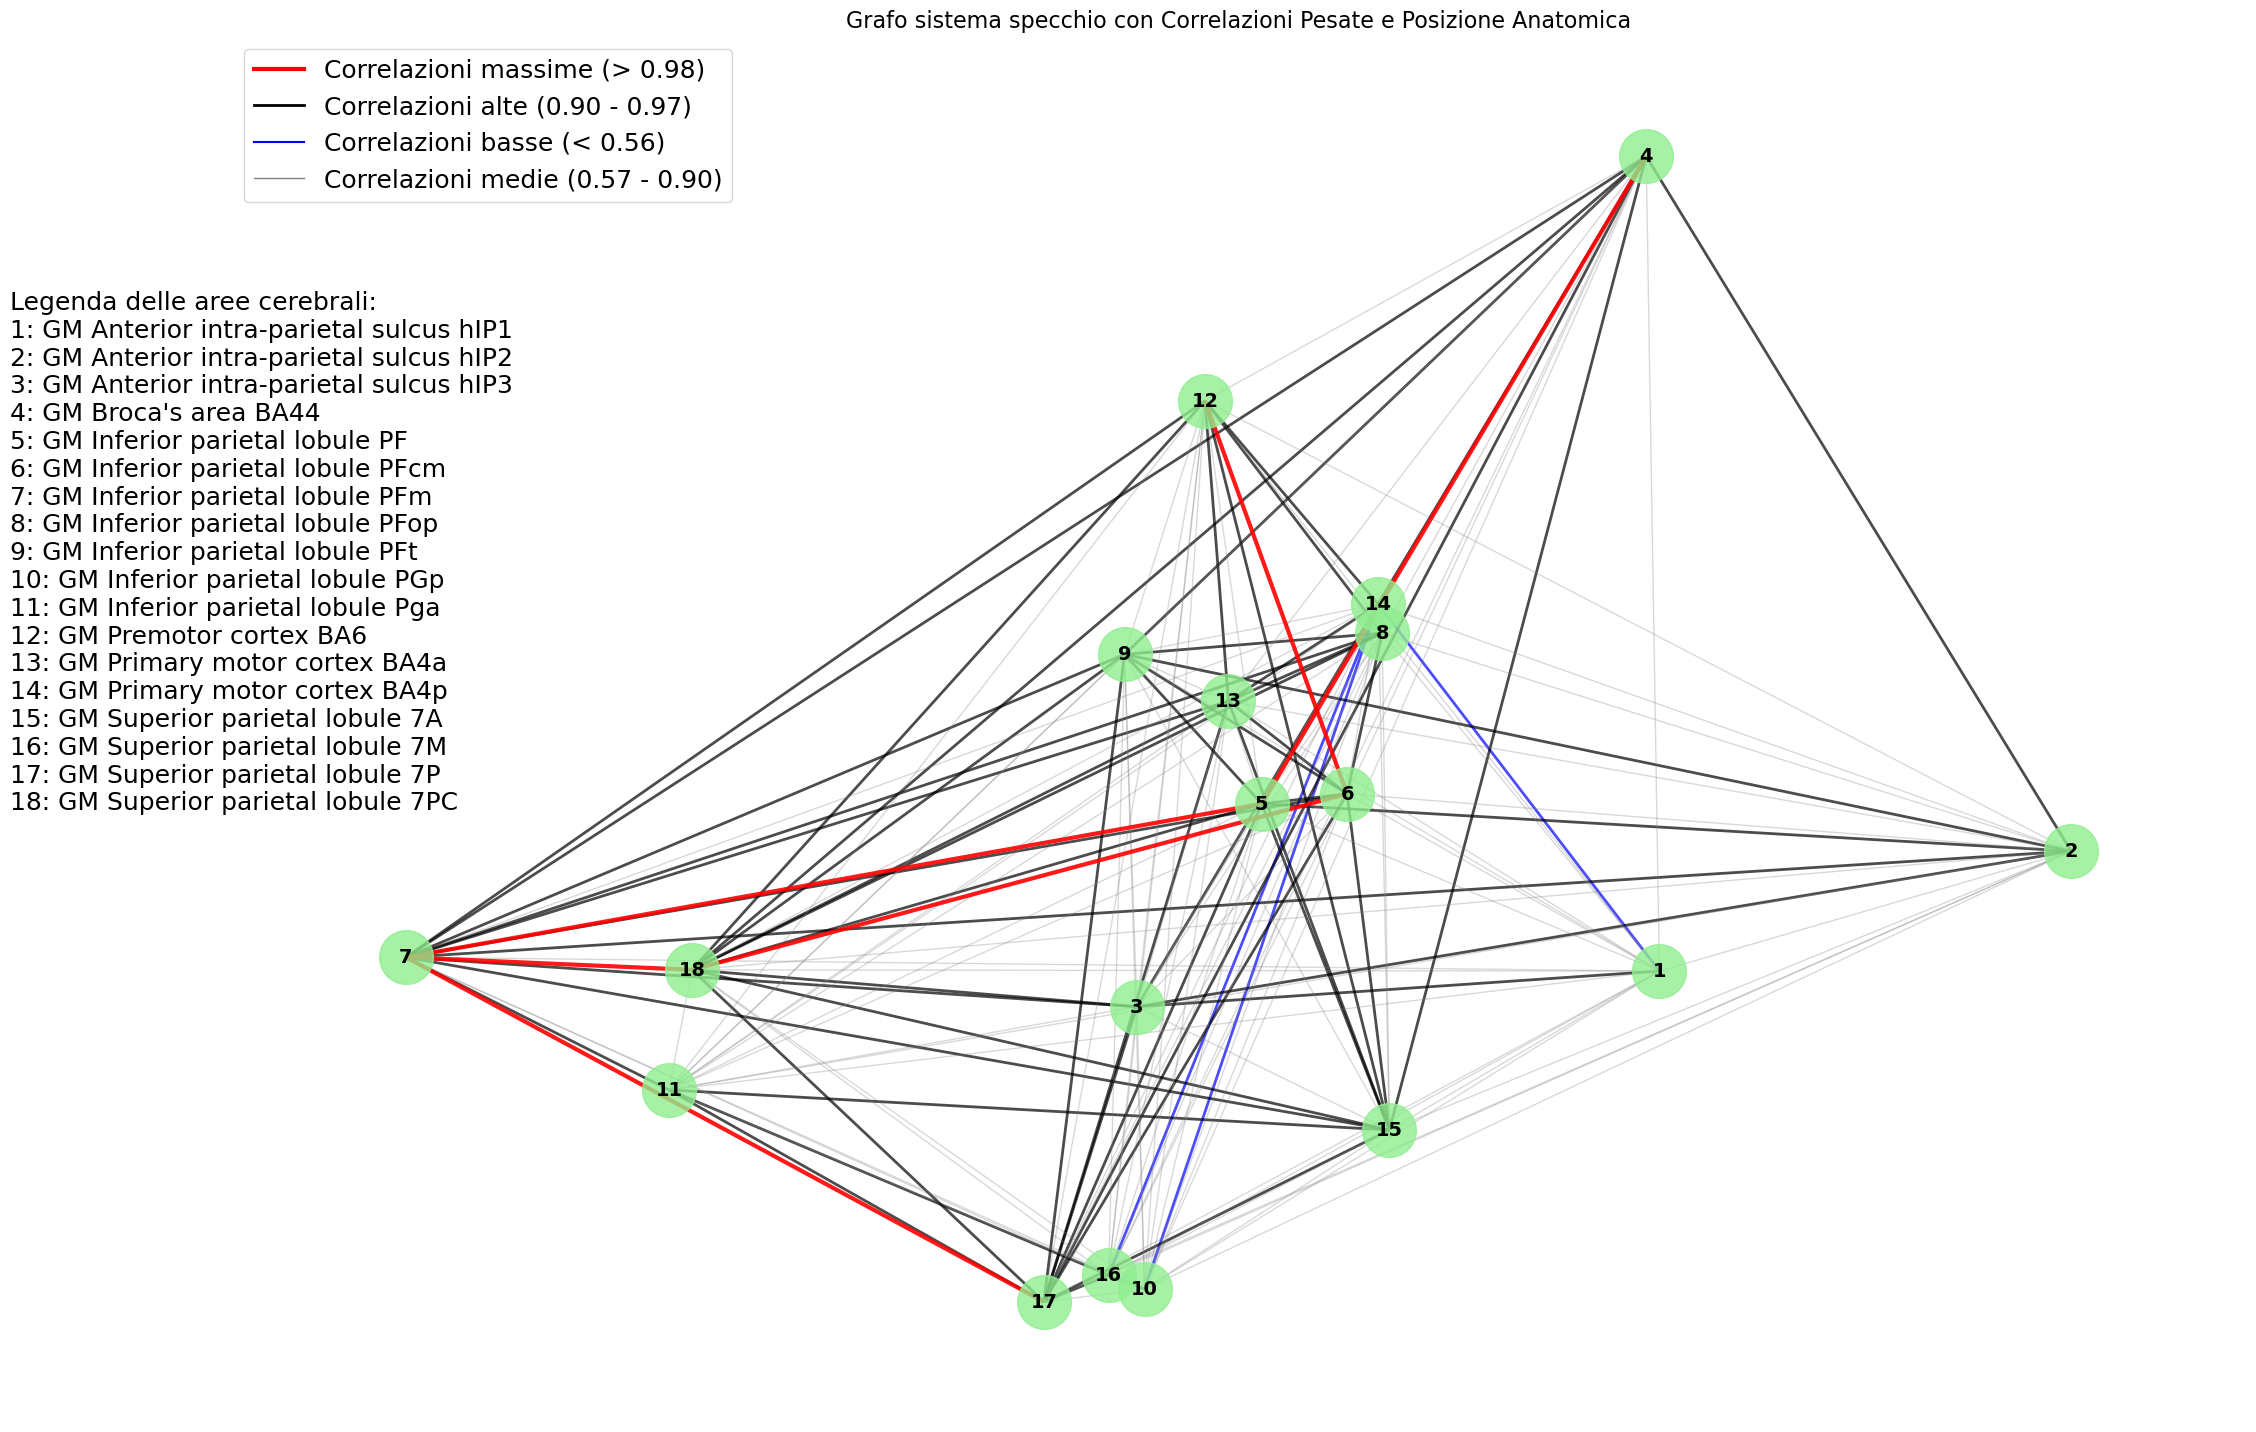

In [73]:
# Dati delle coordinate (x, y) delle aree cerebrali (estratte da 3D)
coordinates = {
    "GM Anterior intra-parietal sulcus hIP1": [-48.0738342, -94.31606218],
    "GM Anterior intra-parietal sulcus hIP2": [-44.19390582, -89.8365651],
    "GM Anterior intra-parietal sulcus hIP3": [-52.99664992, -95.64489112],
    "GM Broca's area BA44": [-48.19812383, -63.89193246],
    "GM Inferior parietal lobule PF": [-51.82032478, -88.06914615],
    "GM Inferior parietal lobule PFcm": [-51.01643836, -87.69726027],
    "GM Inferior parietal lobule PFm": [-59.88517442, -93.7994186],
    "GM Inferior parietal lobule PFop": [-50.68587361, -81.69702602],
    "GM Inferior parietal lobule PFt": [-53.11292346, -82.48933501],
    "GM Inferior parietal lobule PGp": [-52.92454998, -106.18690157],
    "GM Inferior parietal lobule Pga": [-57.40584246, -98.75273865],
    "GM Premotor cortex BA6": [-52.35521628, -73.02249364],
    "GM Primary motor cortex BA4a": [-52.13435115, -84.23816794],
    "GM Primary motor cortex BA4p": [-50.72327965, -80.61639824],
    "GM Superior parietal lobule 7A": [-50.61768489, -100.24790997],
    "GM Superior parietal lobule 7M": [-53.26349206, -105.66666667],
    "GM Superior parietal lobule 7P": [-53.87253521, -106.66056338],
    "GM Superior parietal lobule 7PC": [-57.18971631, -94.2677305]
}

G = nx.Graph()

for region_name, coord in coordinates.items():
    G.add_node(region_name, pos=coord)

for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        correlation_value = correlation_matrix.iloc[i, j]
        region1 = correlation_matrix.columns[i]
        region2 = correlation_matrix.columns[j]
        G.add_edge(region1, region2, weight=correlation_value)

pos = nx.get_node_attributes(G, 'pos')

high_corr_edges = []
low_corr_edges = []
medium_corr_edges = []
max_corr_edges = []  

for edge in G.edges(data=True):
    weight = edge[2]['weight']
    if weight > 0.98:
        max_corr_edges.append(edge)  
    elif weight > 0.90:
        high_corr_edges.append(edge)  
    elif weight < 0.56:
        low_corr_edges.append(edge)  
    else:
        medium_corr_edges.append(edge)  

plt.figure(figsize=(26, 18))  

nx.draw_networkx_nodes(G, pos, node_size=1500, node_color='lightgreen', alpha=0.8)

nx.draw_networkx_edges(G, pos, edgelist=low_corr_edges, width=2, alpha=0.7, edge_color='blue')

nx.draw_networkx_edges(G, pos, edgelist=high_corr_edges, width=2, alpha=0.7, edge_color='black')

nx.draw_networkx_edges(G, pos, edgelist=medium_corr_edges, width=1, alpha=0.3, edge_color='gray')

nx.draw_networkx_edges(G, pos, edgelist=max_corr_edges, width=3, alpha=0.9, edge_color='red')


region_numbers = {region: str(i) for i, region in enumerate(coordinates.keys(), 1)}
nx.draw_networkx_labels(G, pos, labels=region_numbers, font_size=14, font_weight='bold', font_color='black')

legend_elements = [
    Line2D([0], [0], color='red', lw=3, label='Correlazioni massime (> 0.98)'),
    Line2D([0], [0], color='black', lw=2, label='Correlazioni alte (0.90 - 0.97)'),
    Line2D([0], [0], color='blue', lw=1.5, label='Correlazioni basse (< 0.56)'),
    Line2D([0], [0], color='gray', lw=1, label='Correlazioni medie (0.57 - 0.90)'),
]

plt.legend(handles=legend_elements, loc='upper left', fontsize=18)

area_labels = {i: area for i, area in enumerate(coordinates.keys(), 1)}
plt.figtext(0.04, 0.45, "Legenda delle aree cerebrali:\n" + "\n".join([f"{k}: {v}" for k, v in area_labels.items()]),
            ha="left", fontsize=18)

plt.title("Grafo sistema specchio con Correlazioni Pesate e Posizione Anatomica", fontsize=16)

plt.axis('off')

plt.show()

In [74]:
output_csv_path = "/Users/digitalangels/Desktop/data/mirror_graph_edges.csv"
edges = [(u, v, data['weight']) for u, v, data in G.edges(data=True)]
edges_df = pd.DataFrame(edges, columns=["source", "target", "weight"])
edges_df.to_csv(output_csv_path, index=False)
print(f"Grafo esportato in formato CSV in: {output_csv_path}")

Grafo esportato in formato CSV in: /Users/digitalangels/Desktop/data/mirror_graph_edges.csv


## Analisi del grafo maschera 

In [75]:
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
density = nx.density(G)
average_degree = np.mean([deg for node, deg in G.degree()])
assortativity = nx.degree_assortativity_coefficient(G)
clustering_coefficient = nx.average_clustering(G)
diameter = nx.diameter(G) if nx.is_connected(G) else "Inf"  # Diametro se il grafo è connesso
avg_shortest_path = nx.average_shortest_path_length(G) if nx.is_connected(G) else "Inf"  # Lunghezza media del cammino più breve

print("Grafico delle statistiche di base:")
print(f"Numero di nodi: {num_nodes}")
print(f"Numero di archi: {num_edges}")
print(f"Densità del grafo: {density}")
print(f"Assortatività del grafo: {assortativity}")
print(f"Grado medio: {average_degree}")
print(f"Coefficiente di clustering medio: {clustering_coefficient}")
print(f"Diametro del grafo: {diameter}")
print(f"Lunghezza media del cammino più breve: {avg_shortest_path}")


Grafico delle statistiche di base:
Numero di nodi: 18
Numero di archi: 153
Densità del grafo: 1.0
Assortatività del grafo: nan
Grado medio: 17.0
Coefficiente di clustering medio: 1.0
Diametro del grafo: 1
Lunghezza media del cammino più breve: 1.0


/opt/anaconda3/envs/neuro_env/lib/python3.9/site-packages/networkx/algorithms/assortativity/correlation.py:302: RuntimeWarning:

invalid value encountered in scalar divide



In [76]:
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)

In [77]:
sorted_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)
sorted_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)

# I primi 5 hubs (nodi con il grado maggiore)
print("Top 5 Hubs (centralità di grado):")
for node, value in sorted_degree[:5]:
    print(f"{node}: {value}")

# I primi 5 influencer (nodi con la maggiore centralità di intermediazione)
print("\nTop 5 Influencer (centralità di intermediazione):")
for node, value in sorted_betweenness[:5]:
    print(f"{node}: {value}")


Top 5 Hubs (centralità di grado):
GM Anterior intra-parietal sulcus hIP1: 1.0
GM Anterior intra-parietal sulcus hIP2: 1.0
GM Anterior intra-parietal sulcus hIP3: 1.0
GM Broca's area BA44: 1.0
GM Inferior parietal lobule PF: 1.0

Top 5 Influencer (centralità di intermediazione):
GM Anterior intra-parietal sulcus hIP1: 0.0
GM Anterior intra-parietal sulcus hIP2: 0.0
GM Anterior intra-parietal sulcus hIP3: 0.0
GM Broca's area BA44: 0.0
GM Inferior parietal lobule PF: 0.0


In [78]:
node_corr_high = {node: 0 for node in G.nodes}
for edge in high_corr_edges:
    node_corr_high[edge[0]] += 1
    node_corr_high[edge[1]] += 1

top_high_corr_nodes = sorted(node_corr_high.items(), key=lambda x: x[1], reverse=True)

print("\nTop 5 nodi con più archi con correlazioni alte (> 0.90):")
for i, (node, count) in enumerate(top_high_corr_nodes[:5]):
    print(f"{i+1}. {node}: {count} archi")


Top 5 nodi con più archi con correlazioni alte (> 0.90):
1. GM Inferior parietal lobule PFm: 10 archi
2. GM Superior parietal lobule 7P: 10 archi
3. GM Superior parietal lobule 7A: 9 archi
4. GM Superior parietal lobule 7PC: 9 archi
5. GM Inferior parietal lobule PFt: 8 archi


In [79]:
partition = community_louvain.best_partition(G)

/var/folders/z5/ql92fy5n5md52b43qh02f6km0000gn/T/ipykernel_89255/1388092759.py:6: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



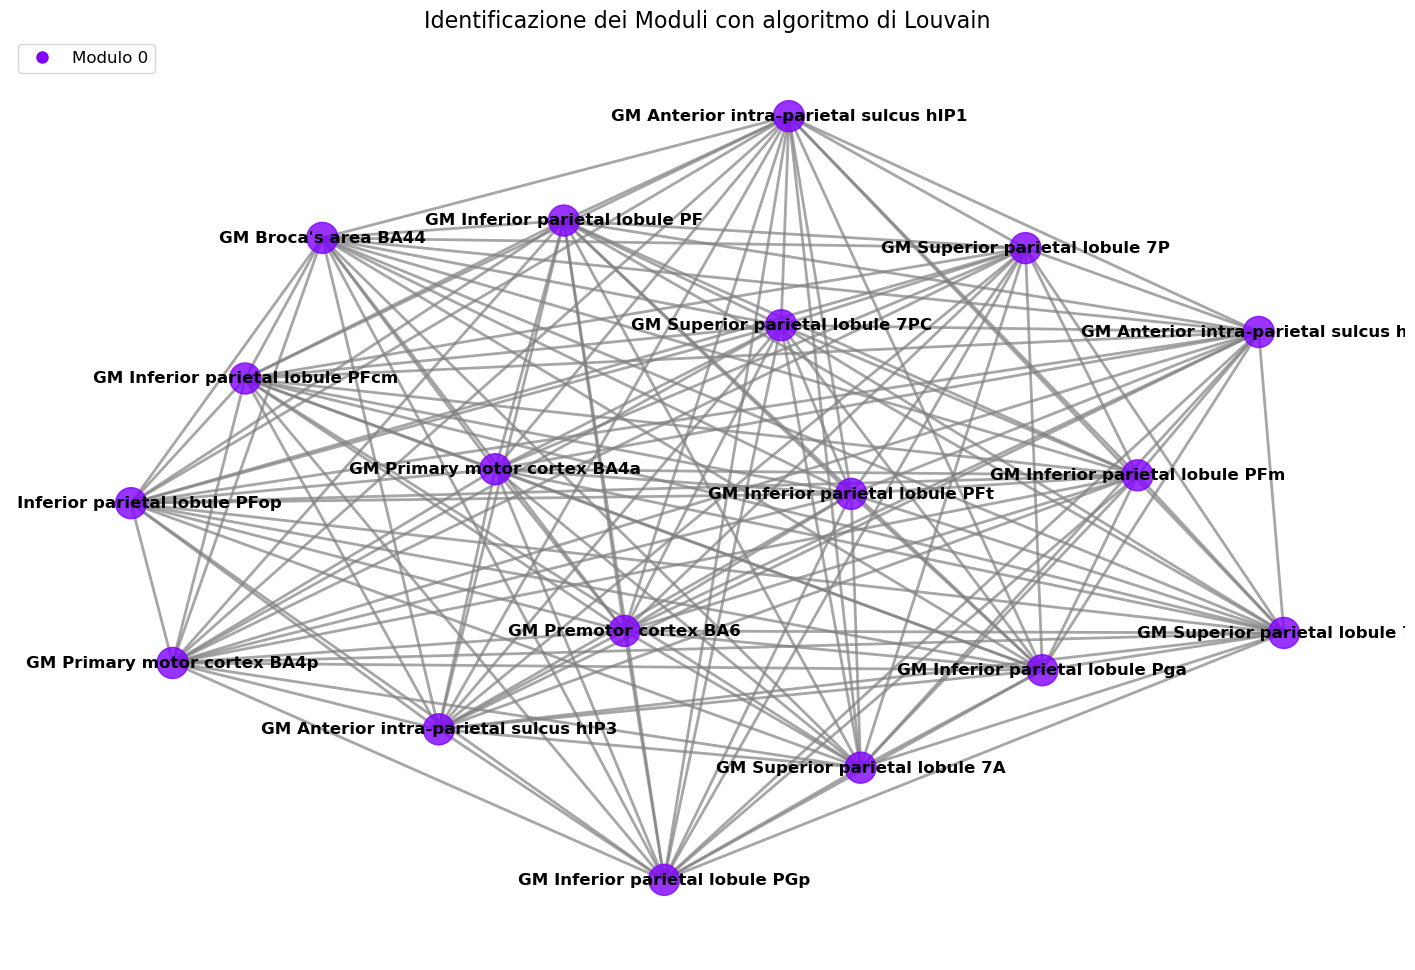

Divisione in moduli:
Comunità GM Anterior intra-parietal sulcus hIP1: 0
Comunità GM Anterior intra-parietal sulcus hIP2: 0
Comunità GM Anterior intra-parietal sulcus hIP3: 0
Comunità GM Broca's area BA44: 0
Comunità GM Inferior parietal lobule PF: 0
Comunità GM Inferior parietal lobule PFcm: 0
Comunità GM Inferior parietal lobule PFm: 0
Comunità GM Inferior parietal lobule PFop: 0
Comunità GM Inferior parietal lobule PFt: 0
Comunità GM Inferior parietal lobule PGp: 0
Comunità GM Inferior parietal lobule Pga: 0
Comunità GM Premotor cortex BA6: 0
Comunità GM Primary motor cortex BA4a: 0
Comunità GM Primary motor cortex BA4p: 0
Comunità GM Superior parietal lobule 7A: 0
Comunità GM Superior parietal lobule 7M: 0
Comunità GM Superior parietal lobule 7P: 0
Comunità GM Superior parietal lobule 7PC: 0


In [80]:
pos = nx.spring_layout(G, seed=42, k=0.2)  

plt.figure(figsize=(18, 12))

node_colors = [partition[node] for node in G.nodes()]
cmap = plt.cm.get_cmap('rainbow', max(node_colors) + 1)  


nx.draw_networkx_nodes(G, pos, node_size=500, node_color=node_colors, cmap=cmap, alpha=0.8)


nx.draw_networkx_edges(G, pos, alpha=0.7, width=2, edge_color='gray')


nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold', font_color='black')


plt.title("Identificazione dei Moduli con algoritmo di Louvain", fontsize=16)


plt.axis('off')

legend_elements = [Line2D([0], [0], marker='o', color='w', label=f"Modulo {i}", 
                          markerfacecolor=cmap(i), markersize=10) for i in range(max(node_colors) + 1)]

plt.legend(handles=legend_elements, loc='upper left', fontsize=12)

plt.show()

print("Divisione in moduli:")
for community, nodes in partition.items():
    print(f"Comunità {community}: {nodes}")

## Maschera con tutte le regioni

In [81]:
juelich_atlas = datasets.fetch_atlas_juelich('maxprob-thr25-1mm')
juelich_atlas_img = juelich_atlas.maps  # Oggetto NIfTI
juelich_data = juelich_atlas_img.get_fdata()
print(f"Dimensioni dell'atlante Juelich: {juelich_data.shape} (x, y, z)")

Dimensioni dell'atlante Juelich: (182, 218, 182) (x, y, z)


In [82]:
all_regions = np.unique(juelich_data)
all_regions = all_regions[all_regions > 0] 
print(f"Regioni disponibili nell'atlante: {all_regions}")

Regioni disponibili nell'atlante: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.
 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53. 54.
 55. 56. 57. 58. 59. 60. 61. 62.]


In [83]:
juelich_full_mask = np.zeros_like(juelich_data, dtype=np.int16)

In [84]:
for region in all_regions:
    juelich_full_mask[juelich_data == region] = region

# Controlla i valori unici nella nuova maschera
print(f"Valori unici nella maschera completa: {np.unique(juelich_full_mask)}")

Valori unici nella maschera completa: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62]


In [85]:
juelich_full_mask_img = nib.Nifti1Image(juelich_full_mask, affine=juelich_atlas_img.affine)

In [86]:
resampled_full_mask_img = resample_to_img(
    source_img=juelich_full_mask_img, 
    target_img=fmri_img, 
    interpolation="nearest"
)

In [87]:
output_path = "/Users/digitalangels/Desktop/data/resampled_full_mask_img"
nib.save(resampled_full_mask_img, output_path)
print(f"Maschera resampled salvata in: {output_path}")

Maschera resampled salvata in: /Users/digitalangels/Desktop/data/resampled_full_mask_img


In [88]:
resampled_full_mask_data = resampled_full_mask_img.get_fdata().astype(np.int16)
print(f"Valori unici nella maschera resample-ata: {np.unique(resampled_full_mask_data)}")

Valori unici nella maschera resample-ata: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62]


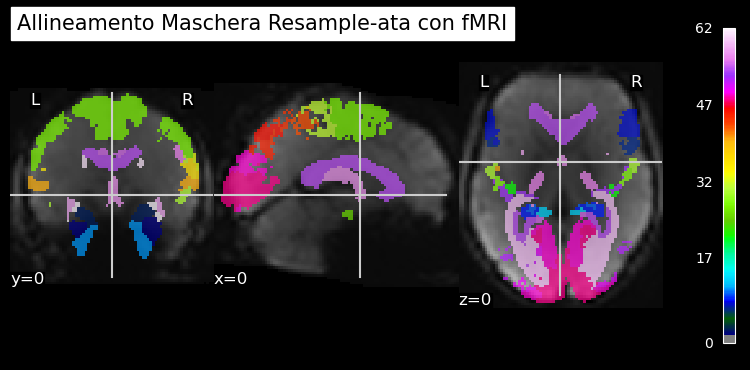

In [89]:
if len(fmri_img.shape) == 4:
    fmri_img_display = image.mean_img(fmri_img)  # Media nel tempo
else:
    fmri_img_display = fmri_img  # Caso 3D

plot_roi(
    resampled_full_mask_img,
    bg_img=fmri_img_display,
    title="Allineamento Maschera Resample-ata con fMRI",
    display_mode='ortho',
    cut_coords=(0, 0, 0),  
    colorbar=True
)

plt.show()

In [90]:
resampled_regions = np.unique(resampled_full_mask_data)
resampled_regions = resampled_regions[resampled_regions > 0]  # Escludi lo sfondo (0)

missing_regions = set(all_regions) - set(resampled_regions)

print(f"Numero totale di regioni nell'atlante originale: {len(all_regions)}")
print(f"Numero di regioni trovate nella maschera resample-ata: {len(resampled_regions)}")
if missing_regions:
    print(f"Regioni mancanti nella maschera resample-ata: {missing_regions}")
else:
    print("Tutte le regioni dell'atlante sono state mappate correttamente!")

Numero totale di regioni nell'atlante originale: 62
Numero di regioni trovate nella maschera resample-ata: 62
Tutte le regioni dell'atlante sono state mappate correttamente!


## correlazioni e serie temporali maschera completa 

In [91]:
masker = NiftiLabelsMasker(labels_img=resampled_full_mask_img, standardize=True)
time_series = masker.fit_transform(fmri_img)

In [92]:
correlation_matrix = np.corrcoef(time_series.T)  
num_areas = correlation_matrix.shape[0]

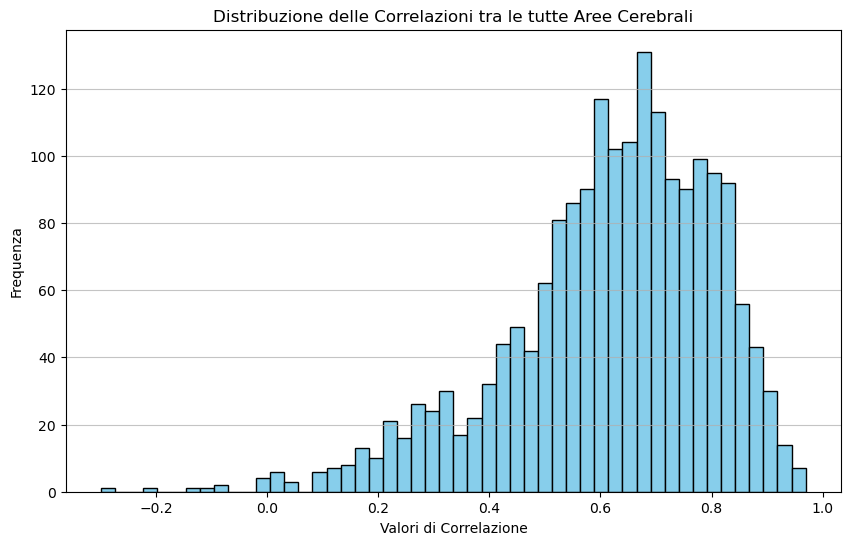

In [93]:
correlation_values = correlation_matrix[np.triu_indices_from(correlation_matrix, k=1)]

plt.figure(figsize=(10, 6))
plt.hist(correlation_values, bins=50, color='skyblue', edgecolor='black')
plt.title("Distribuzione delle Correlazioni tra le tutte Aree Cerebrali")
plt.xlabel("Valori di Correlazione")
plt.ylabel("Frequenza")
plt.grid(axis='y', alpha=0.75)
plt.show()

In [94]:
correlation_values_df = pd.DataFrame(correlation_values, columns=["correlation"])
output_csv_path = "/Users/digitalangels/Desktop/data/global_correlation_values.csv"
correlation_values_df.to_csv(output_csv_path, index=False)
print(f"Valori di correlazione salvati in: {output_csv_path}")

Valori di correlazione salvati in: /Users/digitalangels/Desktop/data/global_correlation_values.csv


In [95]:
juelich_labels = juelich_atlas.labels

In [96]:
region_index_to_name = {index: name for index, name in enumerate(juelich_labels)}

In [97]:
pairs_named = []
for i in range(correlation_matrix.shape[0]):
    for j in range(i + 1, correlation_matrix.shape[1]):  # Parte superiore della matrice
        correlation = correlation_matrix[i, j]
        if 0.0 <= correlation <= 0.40:
            region1 = region_index_to_name.get(all_regions[i], f"Region {all_regions[i]}")
            region2 = region_index_to_name.get(all_regions[j], f"Region {all_regions[j]}")
            pairs_named.append((region1, region2, correlation))

In [98]:
pairs_named_df = pd.DataFrame(pairs_named, columns=["Regione 1", "Regione 2", "Correlazione"])

In [99]:
pairs_named_df = pairs_named_df.sort_values(by="Correlazione", ascending=True)

In [100]:
pairs_named_df

Regione 1  \
62     GM Amygdala_laterobasal group   
13    GM Amygdala_centromedial group   
102     GM Hippocampus cornu ammonis   
171  GM Inferior parietal lobule PGp   
52     GM Amygdala_laterobasal group   
..                               ...   
218        GM Medial geniculate body   
185  GM Inferior parietal lobule Pga   
73     GM Amygdala_laterobasal group   
156  GM Inferior parietal lobule PGp   
58     GM Amygdala_laterobasal group   

                                             Regione 2  Correlazione  
62   GM Secondary somatosensory cortex / Parietal o...      0.001365  
13                          GM Lateral geniculate body      0.012387  
102  GM Secondary somatosensory cortex / Parietal o...      0.016164  
171                               GM Visual cortex V3V      0.016659  
52                          GM Lateral geniculate body      0.018613  
..                                                 ...           ...  
218                   GM Primary auditory cortex TE1.2      0.395764  
185                               GM Visual cortex V3V      0.397889  
73                               WM Acoustic radiation      0.397895  
156                   GM Primary auditory cortex TE1.1      0.398397  
58                 GM Primary somatosensory cortex BA1      0.398477  

[226 rows x 3 columns]

In [101]:
pairs_named_df.describe()

Correlazione
count    226.000000
mean       0.265287
std        0.093788
min        0.001365
25%        0.212991
50%        0.276012
75%        0.334153
max        0.398477

In [102]:
mean_correlation = pairs_named_df["Correlazione"].mean()
std_correlation = pairs_named_df["Correlazione"].std()

threshold = mean_correlation - 2 * std_correlation

low_correlation_df = pairs_named_df[pairs_named_df["Correlazione"] < threshold]

print(f"Media delle correlazioni: {mean_correlation:.2f}")
print(f"Deviazione standard delle correlazioni: {std_correlation:.2f}")
print(f"Soglia (media - 2*std): {threshold:.2f}")

display(low_correlation_df.style.set_table_styles(
    [{'selector': 'th', 'props': [('text-align', 'center')]},
     {'selector': 'td', 'props': [('text-align', 'left')]}]
).set_caption("Aree con Correlazioni Inferiori a Due Deviazioni Standard"))

Media delle correlazioni: 0.27
Deviazione standard delle correlazioni: 0.09
Soglia (media - 2*std): 0.08


## Grafo con tutte le aree cerebrali 

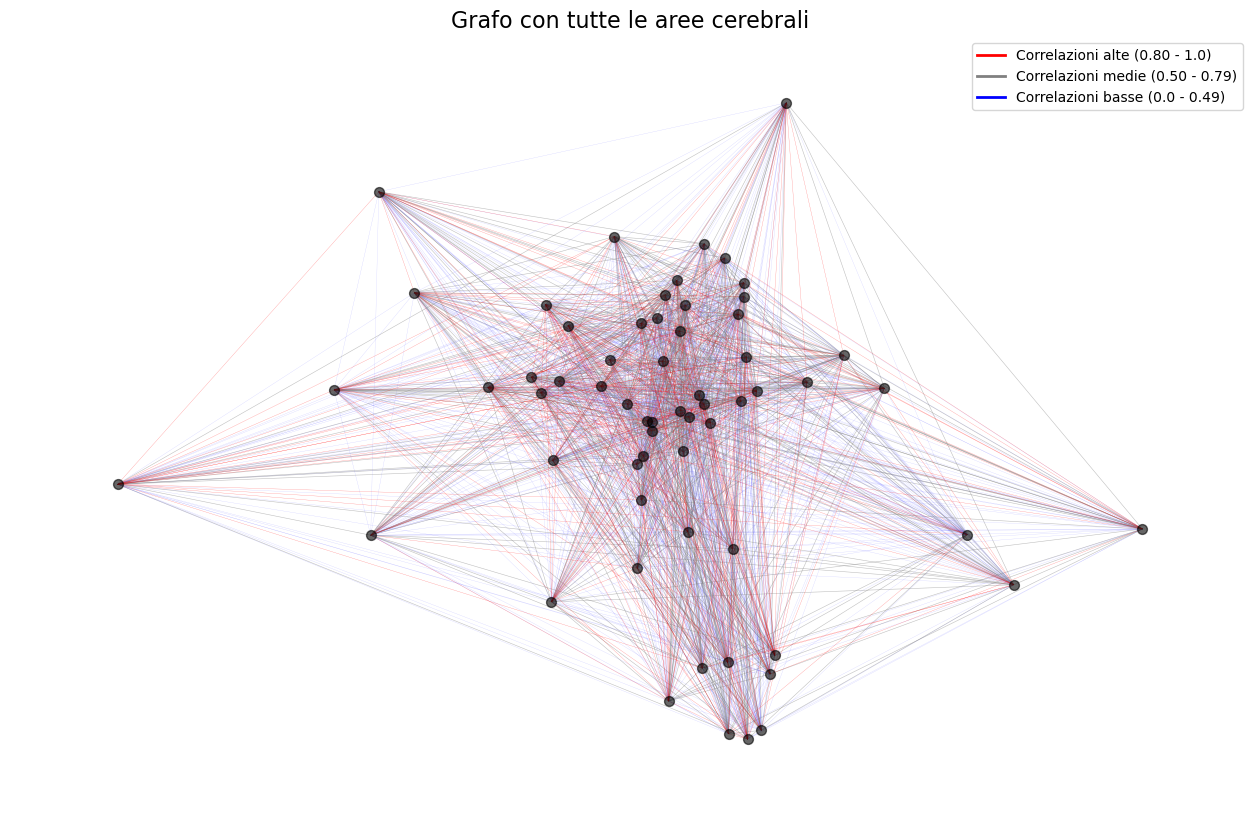

In [103]:
juelich_atlas = datasets.fetch_atlas_juelich('maxprob-thr25-1mm')
juelich_atlas_img = juelich_atlas.maps
juelich_data = juelich_atlas_img.get_fdata()
labels = juelich_atlas['labels']

regions_with_labels = {
    i: label for i, label in enumerate(labels) if label != 'Background'
}

areas_in_mask = np.unique(juelich_data[juelich_data > 0])

coordinates_3d = {}
affine = juelich_atlas_img.affine

for area in areas_in_mask:
    # Trova i voxel della regione
    area_voxels = np.where(juelich_data == area)
    
    voxel_coords = np.vstack((area_voxels[0], area_voxels[1], area_voxels[2], np.ones_like(area_voxels[0])))
    real_coords = np.dot(affine, voxel_coords)[:3].T  # Coordinate 3D
    mean_coordinates = np.mean(real_coords, axis=0)
    
    coordinates_3d[regions_with_labels.get(area, f"Region {int(area)}")] = mean_coordinates

coordinates_2d = {label: (coord[0], coord[1]) for label, coord in coordinates_3d.items()}

G2 = nx.Graph()

for label, coord in coordinates_2d.items():
    G2.add_node(label, pos=coord)

num_areas = len(coordinates_2d)
correlation_matrix = np.random.rand(num_areas, num_areas)  
region_names = list(coordinates_2d.keys())

for i in range(num_areas):
    for j in range(i + 1, num_areas):
        weight = correlation_matrix[i, j]
        G2.add_edge(region_names[i], region_names[j], weight=weight)

pos = nx.get_node_attributes(G2, 'pos')

high_corr_edges = [(u, v) for u, v, d in G2.edges(data=True) if 0.80 <= d['weight'] <= 1.0]
medium_corr_edges = [(u, v) for u, v, d in G2.edges(data=True) if 0.50 <= d['weight'] < 0.80]
low_corr_edges = [(u, v) for u, v, d in G2.edges(data=True) if 0.0 <= d['weight'] < 0.50]

plt.figure(figsize=(16, 10))

nx.draw_networkx_nodes(G2, pos, node_size=50, node_color="black", alpha=0.6)

nx.draw_networkx_edges(G2, pos, edgelist=low_corr_edges, width=0.2, edge_color="blue", alpha=0.2)

nx.draw_networkx_edges(G2, pos, edgelist=medium_corr_edges, width=0.4, edge_color="gray", alpha=0.5)

nx.draw_networkx_edges(G2, pos, edgelist=high_corr_edges, width=0.2, edge_color="red", alpha=0.5)

legend_elements = [
    Line2D([0], [0], color='red', lw=2, label='Correlazioni alte (0.80 - 1.0)'),
    Line2D([0], [0], color='gray', lw=2, label='Correlazioni medie (0.50 - 0.79)'),
    Line2D([0], [0], color='blue', lw=2, label='Correlazioni basse (0.0 - 0.49)')
]
plt.legend(handles=legend_elements, loc='upper right', fontsize=10)

plt.title("Grafo con tutte le aree cerebrali", fontsize=16)
plt.axis('off')
plt.show()

In [104]:
output_csv_path = "/Users/digitalangels/Desktop/data/global_graph_edges.csv"
edges = [(u, v, data['weight']) for u, v, data in G2.edges(data=True)]
edges_df = pd.DataFrame(edges, columns=["source", "target", "weight"])
edges_df.to_csv(output_csv_path, index=False)
print(f"Grafo esportato in formato CSV in: {output_csv_path}")

Grafo esportato in formato CSV in: /Users/digitalangels/Desktop/data/global_graph_edges.csv


In [105]:
num_nodes = G2.number_of_nodes()
num_edges = G2.number_of_edges()
density = nx.density(G2)
average_degree = np.mean([deg for node, deg in G2.degree()])
assortativity = nx.degree_assortativity_coefficient(G2)
clustering_coefficient = nx.average_clustering(G2)
diameter = nx.diameter(G2) if nx.is_connected(G2) else "Inf"  # Diametro se il grafo è connesso
avg_shortest_path = nx.average_shortest_path_length(G2) if nx.is_connected(G2) else "Inf"  # Lunghezza media del cammino più breve

print("Grafico delle statistiche di base:")
print(f"Numero di nodi: {num_nodes}")
print(f"Numero di archi: {num_edges}")
print(f"Densità del grafo: {density}")
print(f"Assortatività del grafo: {assortativity}")
print(f"Grado medio: {average_degree}")
print(f"Coefficiente di clustering medio: {clustering_coefficient}")
print(f"Diametro del grafo: {diameter}")
print(f"Lunghezza media del cammino più breve: {avg_shortest_path}")

Grafico delle statistiche di base:
Numero di nodi: 62
Numero di archi: 1891
Densità del grafo: 1.0
Assortatività del grafo: nan
Grado medio: 61.0
Coefficiente di clustering medio: 1.0
Diametro del grafo: 1
Lunghezza media del cammino più breve: 1.0


/opt/anaconda3/envs/neuro_env/lib/python3.9/site-packages/networkx/algorithms/assortativity/correlation.py:302: RuntimeWarning:

invalid value encountered in scalar divide



In [106]:
degree_centrality = nx.degree_centrality(G2)
betweenness_centrality = nx.betweenness_centrality(G2)

In [107]:
sorted_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)
sorted_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)

# I primi 5 hubs (nodi con il grado maggiore)
print("Top 5 Hubs (centralità di grado):")
for node, value in sorted_degree[:5]:
    print(f"{node}: {value}")

# I primi 5 influencer (nodi con la maggiore centralità di intermediazione)
print("\nTop 5 Influencer (centralità di intermediazione):")
for node, value in sorted_betweenness[:5]:
    print(f"{node}: {value}")

Top 5 Hubs (centralità di grado):
GM Amygdala_centromedial group: 1.0
GM Amygdala_laterobasal group: 1.0
GM Amygdala_superficial group: 1.0
GM Anterior intra-parietal sulcus hIP1: 1.0
GM Anterior intra-parietal sulcus hIP2: 1.0

Top 5 Influencer (centralità di intermediazione):
GM Amygdala_centromedial group: 0.0
GM Amygdala_laterobasal group: 0.0
GM Amygdala_superficial group: 0.0
GM Anterior intra-parietal sulcus hIP1: 0.0
GM Anterior intra-parietal sulcus hIP2: 0.0


In [108]:
node_corr_high = {node: 0 for node in G2.nodes}
for edge in high_corr_edges:
    node_corr_high[edge[0]] += 1
    node_corr_high[edge[1]] += 1

top_high_corr_nodes = sorted(node_corr_high.items(), key=lambda x: x[1], reverse=True)

print("\nTop 5 nodi con più archi con correlazioni alte (> 0.90):")
for i, (node, count) in enumerate(top_high_corr_nodes[:5]):
    print(f"{i+1}. {node}: {count} archi")


Top 5 nodi con più archi con correlazioni alte (> 0.90):
1. GM Primary somatosensory cortex BA3a: 20 archi
2. GM Anterior intra-parietal sulcus hIP2: 17 archi
3. GM Insula Ig2: 16 archi
4. GM Lateral geniculate body: 16 archi
5. GM Secondary somatosensory cortex / Parietal operculum OP1: 16 archi


## Moduli grafo con tutte le regioni cerebrali 

In [109]:
partition2 = community_louvain.best_partition(G2)

/var/folders/z5/ql92fy5n5md52b43qh02f6km0000gn/T/ipykernel_89255/1089894004.py:7: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



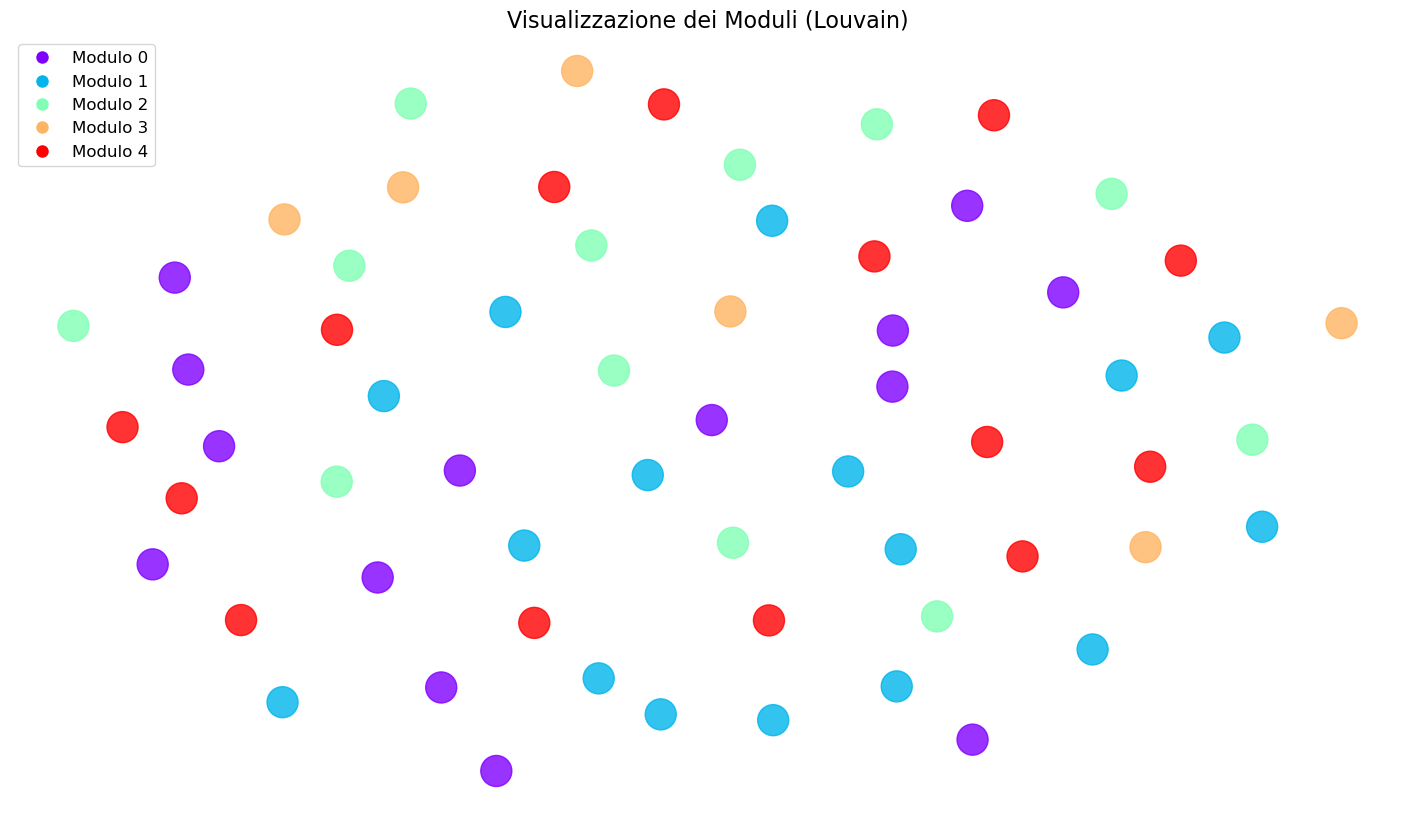

In [131]:
if not partition2:
    print("Errore: partition2 non contiene dati. Assicurati che i moduli siano stati calcolati correttamente.")
else:
    plt.figure(figsize=(18, 10))

    node_colors = [partition2[node] for node in G2.nodes()]
    cmap = plt.cm.get_cmap('rainbow', max(node_colors) + 1)  

    nx.draw_networkx_nodes(G2, pos, node_size=500, node_color=node_colors, cmap=cmap, alpha=0.8)

    plt.title("Visualizzazione dei Moduli (Louvain)", fontsize=16)

    plt.axis('off')

    legend_elements = [Line2D([0], [0], marker='o', color='w', label=f"Modulo {i}",
                              markerfacecolor=cmap(i), markersize=10) for i in range(max(node_colors) + 1)]

    plt.legend(handles=legend_elements, loc='upper left', fontsize=12, frameon=True)

    plt.show()

    communities = {}
    for node, module in partition2.items():
        if module not in communities:
            communities[module] = []
        communities[module].append(node)

    community_data = []
    for module, nodes in communities.items():
        for node in nodes:
            community_data.append({"Modulo": module, "Nodo": node})

    community_df = pd.DataFrame(community_data)

In [111]:
community_df

Modulo                                               Nodo
0        0                     GM Amygdala_centromedial group
1        0                     GM Inferior parietal lobule PF
2        0                   GM Inferior parietal lobule PFcm
3        0                   GM Inferior parietal lobule PFop
4        0                                      GM Insula Ig1
..     ...                                                ...
57       3  GM Hippocampus hippocampal-amygdaloid transiti...
58       3                          GM Medial geniculate body
59       3               GM Primary somatosensory cortex BA3a
60       3  GM Secondary somatosensory cortex / Parietal o...
61       3                     GM Superior parietal lobule 7P

[62 rows x 2 columns]

In [112]:
output_csv_path = "/Users/digitalangels/Desktop/data/global_graph_louvain_community_data.csv"
community_df.to_csv(output_csv_path, index=False)
print(f"Dati delle comunità salvati in: {output_csv_path}")

Dati delle comunità salvati in: /Users/digitalangels/Desktop/data/global_graph_louvain_community_data.csv


In [113]:
communities = {}
for node, module in partition2.items():
    if module not in communities:
        communities[module] = []
    communities[module].append(node)

community_statistics = []

for module, nodes in communities.items():

    num_nodes = len(nodes)

    # Grado medio dei nodi nella comunità
    avg_degree = np.mean([G2.degree[node] for node in nodes])

    subgraph = G2.subgraph(nodes)
    if nx.is_connected(subgraph):
        diameter = nx.diameter(subgraph)
    else:
        diameter = None  

    community_statistics.append({
        "Modulo": module,
        "Numero di Nodi": num_nodes,
        "Grado Medio": avg_degree,
        "Diametro (se connesso)": diameter
    })

statistics_df = pd.DataFrame(community_statistics)

In [114]:
statistics_df

Modulo  Numero di Nodi  Grado Medio  Diametro (se connesso)
0       0              14         61.0                       1
1       4              14         61.0                       1
2       1              16         61.0                       1
3       2              12         61.0                       1
4       3               6         61.0                       1

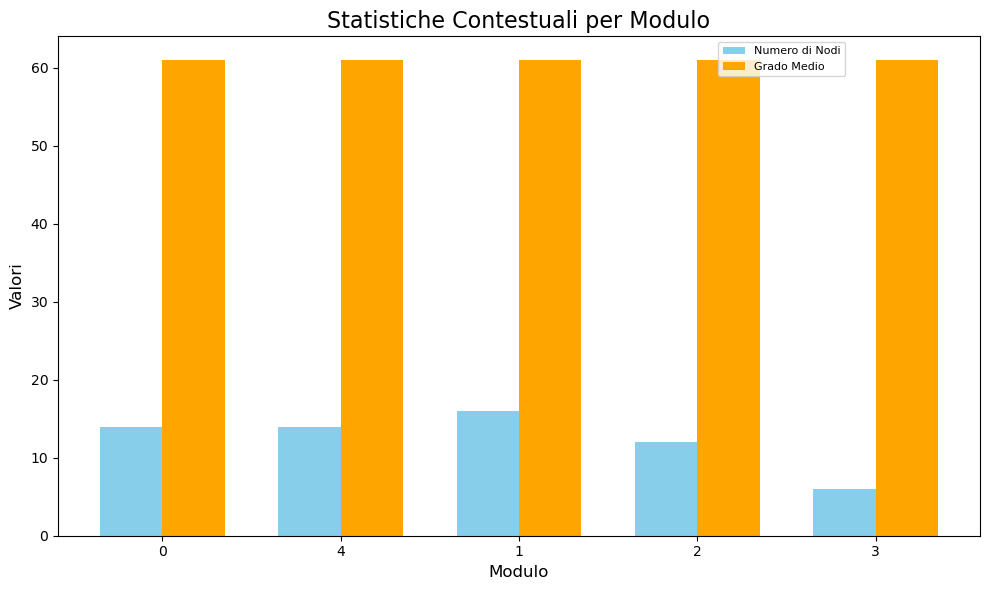

In [115]:
x = np.arange(len(statistics_df["Modulo"]))

width = 0.35

plt.figure(figsize=(10, 6))

plt.bar(x - width/2, statistics_df["Numero di Nodi"], width, label="Numero di Nodi", color="skyblue")

plt.bar(x + width/2, statistics_df["Grado Medio"], width, label="Grado Medio", color="orange")

plt.title("Statistiche Contestuali per Modulo", fontsize=16)
plt.xlabel("Modulo", fontsize=12)
plt.ylabel("Valori", fontsize=12)
plt.xticks(x, statistics_df["Modulo"])
plt.legend(bbox_to_anchor=(0.71, 1), loc='upper left', fontsize=8) 

plt.tight_layout()
plt.show()

In [116]:
grouped_communities = community_df.groupby("Modulo")["Nodo"].apply(list).reset_index()

for index, row in grouped_communities.iterrows():
    print(f"Modulo {row['Modulo']}:")
    print(", ".join(row["Nodo"]))
    print("\n" + "-"*50 + "\n")

Modulo 0:
GM Amygdala_centromedial group, GM Inferior parietal lobule PF, GM Inferior parietal lobule PFcm, GM Inferior parietal lobule PFop, GM Insula Ig1, GM Primary auditory cortex TE1.0, GM Secondary somatosensory cortex / Parietal operculum OP1, GM Superior parietal lobule 5Ci, GM Superior parietal lobule 5M, GM Superior parietal lobule 7M, GM Visual cortex V1 BA17, GM Visual cortex V2 BA18, GM Visual cortex V3V, WM Callosal body

--------------------------------------------------

Modulo 1:
GM Amygdala_superficial group, GM Anterior intra-parietal sulcus hIP1, GM Hippocampus dentate gyrus, GM Hippocampus subiculum, GM Insula Ig2, GM Lateral geniculate body, GM Primary somatosensory cortex BA3b, GM Secondary somatosensory cortex / Parietal operculum OP3, GM Visual cortex V4, WM Acoustic radiation, WM Cingulum, WM Fornix, WM Inferior occipito-frontal fascicle, WM Optic radiation, WM Superior occipito-frontal fascicle, WM Uncinate fascicle

------------------------------------------

### valutiamo se la maschera del sistema specchio viene raggruppata in uno di questi moduli 

In [117]:
labels_to_check = [
    "GM Anterior intra-parietal sulcus hIP1",
    "GM Anterior intra-parietal sulcus hIP2",
    "GM Anterior intra-parietal sulcus hIP3",
    "GM Broca's area BA44",
    "GM Inferior parietal lobule PF",
    "GM Inferior parietal lobule PFcm",
    "GM Inferior parietal lobule PFm",
    "GM Inferior parietal lobule PFop",
    "GM Inferior parietal lobule PFt",
    "GM Inferior parietal lobule PGp",
    "GM Inferior parietal lobule Pga",
    "GM Premotor cortex BA6",
    "GM Primary motor cortex BA4a",
    "GM Primary motor cortex BA4p",
    "GM Superior parietal lobule 7A",
    "GM Superior parietal lobule 7M",
    "GM Superior parietal lobule 7P",
    "GM Superior parietal lobule 7PC",
]

# Dizionario con i moduli (modules)
modules = {
    0: [
        "Background", "GM Amygdala_centromedial group", "GM Amygdala_laterobasal group", "GM Broca's area BA44",
        "GM Broca's area BA45", "GM Hippocampus cornu ammonis", "GM Hippocampus dentate gyrus",
        "GM Hippocampus entorhinal cortex", "GM Hippocampus hippocampal-amygdaloid transition area",
        "GM Inferior parietal lobule PGp", "GM Insula Id1", "GM Insula Ig1", "GM Lateral geniculate body",
        "GM Premotor cortex BA6", "GM Primary auditory cortex TE1.1",
        "GM Secondary somatosensory cortex / Parietal operculum OP2",
        "GM Secondary somatosensory cortex / Parietal operculum OP3",
        "GM Superior parietal lobule 5Ci", "GM Superior parietal lobule 5M", "GM Visual cortex V5",
        "WM Acoustic radiation", "WM Callosal body", "WM Corticospinal tract", "WM Fornix",
        "WM Superior occipito-frontal fascicle",
    ],
    1: ["GM Superior parietal lobule 7PC", "GM Visual cortex V1 BA17", "GM Visual cortex V2 BA18", "GM Visual cortex V3V"],
    2: [
        "GM Amygdala_superficial group", "GM Anterior intra-parietal sulcus hIP1", "GM Anterior intra-parietal sulcus hIP2",
        "GM Anterior intra-parietal sulcus hIP3", "GM Hippocampus subiculum", "GM Inferior parietal lobule PF",
        "GM Inferior parietal lobule PFcm", "GM Inferior parietal lobule PFm", "GM Inferior parietal lobule PFop",
        "GM Inferior parietal lobule PFt", "GM Inferior parietal lobule Pga", "GM Insula Ig2", "GM Mamillary body",
        "GM Medial geniculate body", "GM Primary auditory cortex TE1.0", "GM Primary auditory cortex TE1.2",
        "GM Primary motor cortex BA4a", "GM Primary motor cortex BA4p", "GM Primary somatosensory cortex BA1",
        "GM Primary somatosensory cortex BA2", "GM Primary somatosensory cortex BA3a", "GM Primary somatosensory cortex BA3b",
        "GM Secondary somatosensory cortex / Parietal operculum OP1", "GM Secondary somatosensory cortex / Parietal operculum OP4",
        "GM Superior parietal lobule 5L", "GM Superior parietal lobule 7A", "GM Superior parietal lobule 7M",
        "GM Superior parietal lobule 7P", "GM Visual cortex V4", "WM Cingulum", "WM Inferior occipital fascicle",
    ],
}

for label in labels_to_check:
    found_in_modules = [module for module, regions in modules.items() if label in regions]
    if found_in_modules:
        print(f"'{label}' si trova nei moduli: {found_in_modules}")
    else:
        print(f"'{label}' non è stato trovato in nessun modulo.")


'GM Anterior intra-parietal sulcus hIP1' si trova nei moduli: [2]
'GM Anterior intra-parietal sulcus hIP2' si trova nei moduli: [2]
'GM Anterior intra-parietal sulcus hIP3' si trova nei moduli: [2]
'GM Broca's area BA44' si trova nei moduli: [0]
'GM Inferior parietal lobule PF' si trova nei moduli: [2]
'GM Inferior parietal lobule PFcm' si trova nei moduli: [2]
'GM Inferior parietal lobule PFm' si trova nei moduli: [2]
'GM Inferior parietal lobule PFop' si trova nei moduli: [2]
'GM Inferior parietal lobule PFt' si trova nei moduli: [2]
'GM Inferior parietal lobule PGp' si trova nei moduli: [0]
'GM Inferior parietal lobule Pga' si trova nei moduli: [2]
'GM Premotor cortex BA6' si trova nei moduli: [0]
'GM Primary motor cortex BA4a' si trova nei moduli: [2]
'GM Primary motor cortex BA4p' si trova nei moduli: [2]
'GM Superior parietal lobule 7A' si trova nei moduli: [2]
'GM Superior parietal lobule 7M' si trova nei moduli: [2]
'GM Superior parietal lobule 7P' si trova nei moduli: [2]
'GM 

In [118]:
region_module_data = []

for label in labels_to_check:
    found_in_modules = [module for module, regions in modules.items() if label in regions]
    region_module_data.append({"Regione": label, "Modulo": found_in_modules[0] if found_in_modules else None})

region_module_df = pd.DataFrame(region_module_data)

grouped_regions = region_module_df.groupby("Modulo")["Regione"].apply(list).reset_index()

print("Regioni raggruppate per modulo:")
for _, row in grouped_regions.iterrows():
    print(f"Modulo {row['Modulo']}:")
    print(", ".join(row["Regione"]))
    print("\n" + "-" * 50 + "\n")


Regioni raggruppate per modulo:
Modulo 0:
GM Broca's area BA44, GM Inferior parietal lobule PGp, GM Premotor cortex BA6

--------------------------------------------------

Modulo 1:
GM Superior parietal lobule 7PC

--------------------------------------------------

Modulo 2:
GM Anterior intra-parietal sulcus hIP1, GM Anterior intra-parietal sulcus hIP2, GM Anterior intra-parietal sulcus hIP3, GM Inferior parietal lobule PF, GM Inferior parietal lobule PFcm, GM Inferior parietal lobule PFm, GM Inferior parietal lobule PFop, GM Inferior parietal lobule PFt, GM Inferior parietal lobule Pga, GM Primary motor cortex BA4a, GM Primary motor cortex BA4p, GM Superior parietal lobule 7A, GM Superior parietal lobule 7M, GM Superior parietal lobule 7P

--------------------------------------------------



Le aree del sistema specchio precedentemente mappate sono quasi tutte raggruppate nel modulo2. E' interessante il fatto che GM Broca's Area BA44, GM Inferior parietal lobule PGp e GM Premotor cortex BA6 sono raggruppate in un unico modulo, in quanto: 

__GM Broca's Area BA44__:

L'area di Broca (specialmente BA44, situata nell'emisfero sinistro) è coinvolta nel linguaggio, ma è anche associata all'osservazione e all'imitazione di azioni, che sono funzioni chiave del sistema specchio.

È parte della rete specchio, poiché è attiva durante compiti di osservazione e comprensione di azioni.

Studi suggeriscono che Broca BA44 potrebbe essere un punto di integrazione tra funzioni motorie e linguistiche.

__GM Inferior Parietal Lobule PGp__:

Il lobulo parietale inferiore (IPL), incluso PGp, è una delle principali aree del sistema specchio.

È coinvolto nell'elaborazione delle intenzioni associate alle azioni, come la comprensione del "perché" dietro un'azione osservata.

IPL lavora insieme alla corteccia premotoria per associare input visivi (osservazione di movimenti) con schemi motori interni.

__GM Premotor Cortex BA6__:

Il BA6 è una regione premotoria fondamentale per il sistema specchio.

È attiva durante l'osservazione e l'esecuzione di movimenti, nonché durante l'imitazione di azioni.

Funziona come un nodo centrale nella rete specchio, integrando informazioni motorie e percettive.


## Confronto grafi (sistema specchio vs tutte le regioni)

In [119]:
is_subgraph = nx.is_isomorphic(G, G2.subgraph(G.nodes))
print(f"Is G a subgraph of G2? {is_subgraph}")

Is G a subgraph of G2? True


In [120]:
node_overlap = len(set(G2.nodes) & set(G.nodes)) / len(G2.nodes)
print(f"Percentuale di nodi di G in G2: {node_overlap * 100:.2f}%")

Percentuale di nodi di G in G2: 29.03%


In [121]:
edge_overlap = len(set(G2.edges) & set(G.edges)) / len(G2.edges)
print(f"Percentuale di archi di G in G2: {edge_overlap * 100:.2f}%")

Percentuale di archi di G in G2: 8.09%


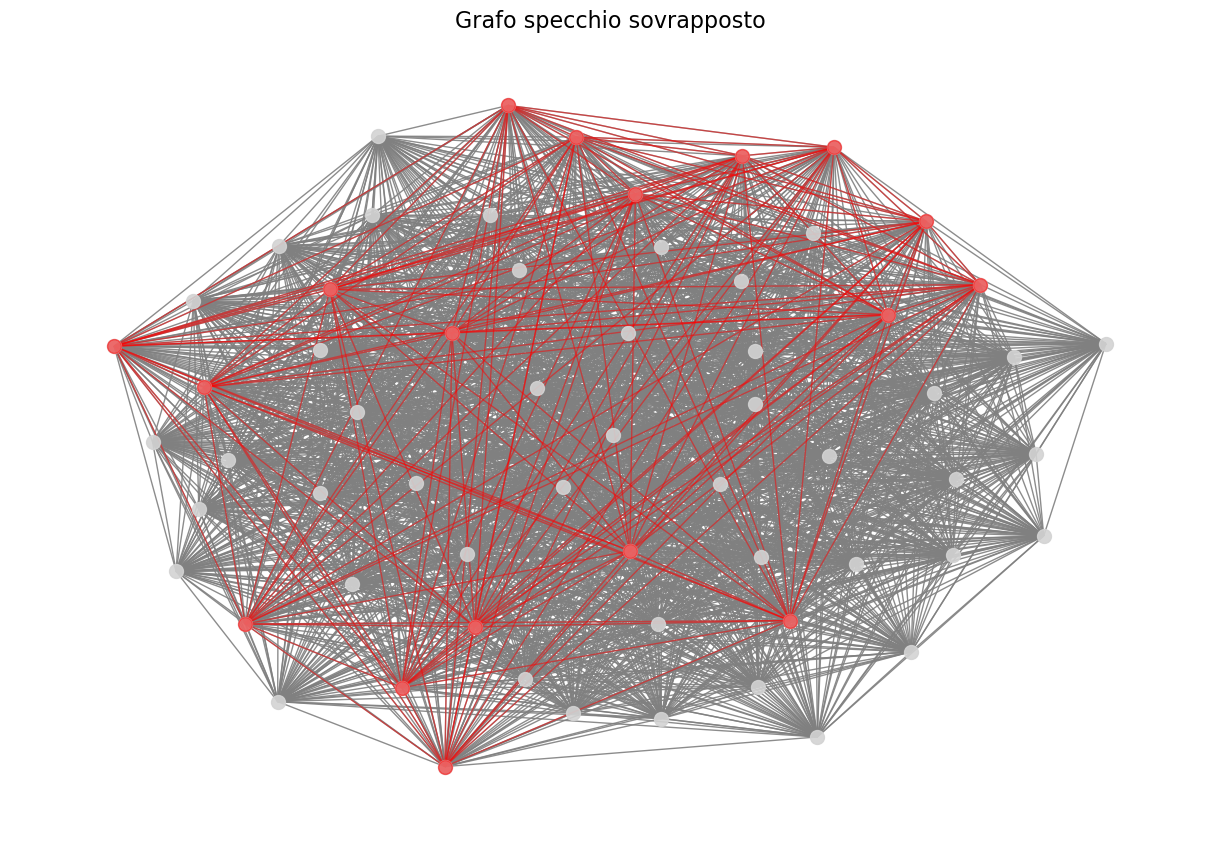

In [122]:
pos = nx.spring_layout(G2, seed=42)  # Seed per layout stabile

plt.figure(figsize=(12, 8))
nx.draw(
    G2, pos, node_color="lightgray", edge_color="gray", with_labels=False, node_size=100, alpha=0.9
)

nx.draw(
    G, pos, node_color="red", edge_color="red", with_labels=False, node_size=100, alpha=0.5
)

plt.title("Grafo specchio sovrapposto", fontsize=16)

plt.show()

In [123]:
def calculate_graph_metrics(graph):
    metrics = {}
    metrics["Numero di nodi"] = graph.number_of_nodes()
    metrics["Numero di archi"] = graph.number_of_edges()
    metrics["Densità"] = nx.density(graph)
    metrics["Diametro"] = nx.diameter(graph) if nx.is_connected(graph) else None
    metrics["Grado medio"] = sum(dict(graph.degree()).values()) / graph.number_of_nodes()
    metrics["Coefficiente di clustering medio"] = nx.average_clustering(graph)
    return metrics

metrics_G = calculate_graph_metrics(G)
metrics_G2 = calculate_graph_metrics(G2)

comparison_df = pd.DataFrame([metrics_G, metrics_G2], index=["G", "G2"])

print("Confronto tra le metriche dei grafi:")
display(comparison_df)

Confronto tra le metriche dei grafi:


Numero di nodi  Numero di archi  Densità  Diametro  Grado medio  \
G               18              153      1.0         1         17.0   
G2              62             1891      1.0         1         61.0   

    Coefficiente di clustering medio  
G                                1.0  
G2                               1.0

In [124]:
output_comparison_path = "/Users/digitalangels/Desktop/data/graph_metrics_comparison.csv"
comparison_df.to_csv(output_comparison_path, index=False)
print(f"Confronto tra le metriche dei grafi salvato in: {output_comparison_path}")

Confronto tra le metriche dei grafi salvato in: /Users/digitalangels/Desktop/data/graph_metrics_comparison.csv


Questi risultati offrono una prospettiva neuroscientifica interessante, sottolineando il ruolo centrale del sistema specchio nell'elaborazione delle emozioni. Il fatto che il sottografo G, che rappresenta solo il 29% dei nodi e il 9% degli archi del grafo completo G2, mostri le stesse metriche di densità, diametro e clustering medio suggerisce che il sistema specchio costituisca un nucleo essenziale ed efficiente per questo specifico compito cognitivo. Nonostante la complessità della rete cerebrale complessiva rappresentata da G2, è evidente che le aree incluse in G, come l'area di Broca (BA44), il lobulo parietale inferiore (PGp) e la corteccia premotoria (BA6), siano sufficientemente interconnesse e ottimizzate per garantire una comunicazione rapida e precisa, necessaria per il riconoscimento emotivo.

Questa osservazione evidenzia come il sistema specchio possa funzionare come una rete specializzata, capace di sostenere da sola gran parte del carico funzionale richiesto dal compito, relegando il resto della rete cerebrale a un ruolo secondario o di supporto. La coesione e la densità massimale delle connessioni all'interno di G riflettono una struttura altamente coordinata, che minimizza la necessità di percorsi lunghi o complessi per la trasmissione dell'informazione. Inoltre, il diametro di 1, costante in entrambe le reti, indica che le informazioni possono essere condivise rapidamente tra tutte le aree, senza la necessità di passaggi intermedi.

Dal punto di vista funzionale, questi risultati possono essere interpretati come una dimostrazione della modularità del cervello. In altre parole, il sistema specchio agisce come un modulo indipendente e autosufficiente, capace di gestire funzioni altamente specifiche, come il riconoscimento delle emozioni. Questo non solo mette in evidenza l'efficienza di questa rete nella gestione del compito, ma suggerisce anche che il resto delle aree cerebrali incluse in G2 potrebbe avere un ruolo ridondante o meno rilevante in questo contesto.

Questi dati rafforzano l'idea che il cervello umano sia organizzato in sottoreti altamente specializzate, che entrano in azione in modo prioritario a seconda delle richieste del compito. Nel caso del riconoscimento emotivo, il sistema specchio emerge come un nucleo funzionale critico, capace di sostenere autonomamente gran parte delle richieste cognitive legate al compito, confermando il suo ruolo centrale nell'elaborazione delle emozioni e nell'empatia.

## Maschera aree sistema specchio maggiormente rilevanti nel compito 

In [125]:
juelich_atlas = datasets.fetch_atlas_juelich('maxprob-thr25-1mm')
juelich_atlas_img = juelich_atlas.maps  # Oggetto NIfTI
juelich_data = juelich_atlas_img.get_fdata()
print(f"Dimensioni dell'atlante Juelich: {juelich_data.shape} (x, y, z)")

Dimensioni dell'atlante Juelich: (182, 218, 182) (x, y, z)


In [126]:
modulo_0_labels = ["GM Broca's area BA44", "GM Inferior parietal lobule PGp", "GM Premotor cortex BA6"]

In [127]:
modulo_0_ids = [i for i, label in enumerate(labels) if label in modulo_0_labels]
print(f"IDs delle regioni nel Modulo 0: {modulo_0_ids}")

IDs delle regioni nel Modulo 0: [7, 19, 27]


In [128]:
modulo_0_mask = np.isin(juelich_data, modulo_0_ids).astype(np.uint8)

In [129]:
resampled_modulo_0_mask_img = resample_to_img(
    source_img=nib.Nifti1Image(modulo_0_mask, juelich_atlas_img.affine),
    target_img=fmri_img,
    interpolation="nearest",
)

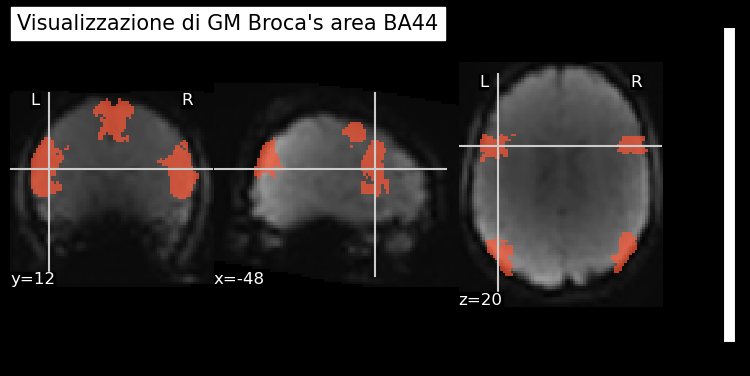

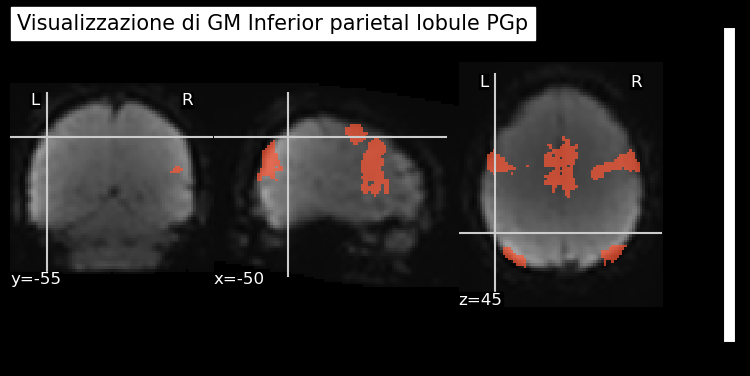

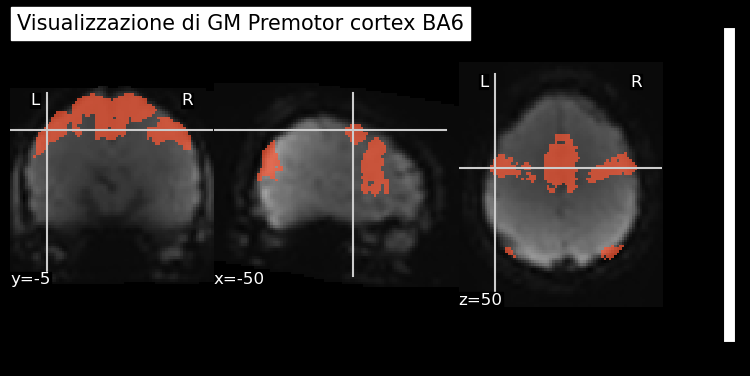

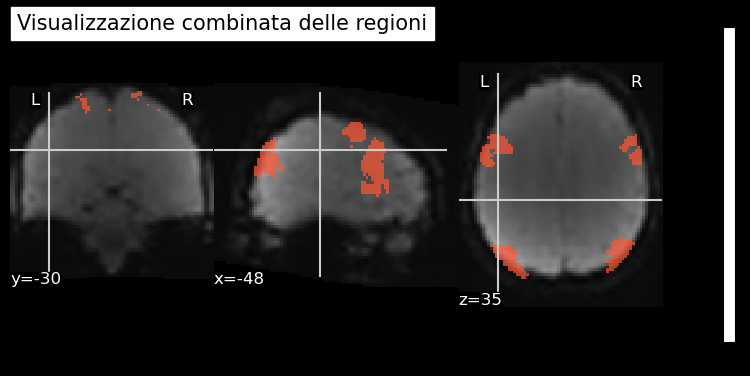

In [130]:
if len(fmri_img.shape) == 4:
    fmri_img_display = image.mean_img(fmri_img)  # Media nel tempo
else:
    fmri_img_display = fmri_img  # Caso 3D

coordinates = {
    "GM Broca's area BA44": (-48, 12, 20),
    "GM Inferior parietal lobule PGp": (-50, -55, 45),
    "GM Premotor cortex BA6": (-50, -5, 50)
}

vivid_cmap = LinearSegmentedColormap.from_list("vivid", ["#FF5733", "#33FF57", "#3357FF"], N=256)

for label, cut_coords in coordinates.items():
    plot_roi(
        resampled_modulo_0_mask_img,  
        bg_img=fmri_img_display,      
        title=f"Visualizzazione di {label}",
        display_mode='ortho',         
        cut_coords=cut_coords,        
        colorbar=True,                
        cmap=vivid_cmap               
    )
    plt.show()

# Visualizzazione combinata (coordinate medie per includere tutte le aree)
cut_coords_combined = (-48, -30, 35)  
plot_roi(
    resampled_modulo_0_mask_img,  
    bg_img=fmri_img_display,     
    title="Visualizzazione combinata delle regioni",
    display_mode='ortho',
    cut_coords=cut_coords_combined,
    colorbar=True,
    cmap=vivid_cmap  
)
plt.show()